The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


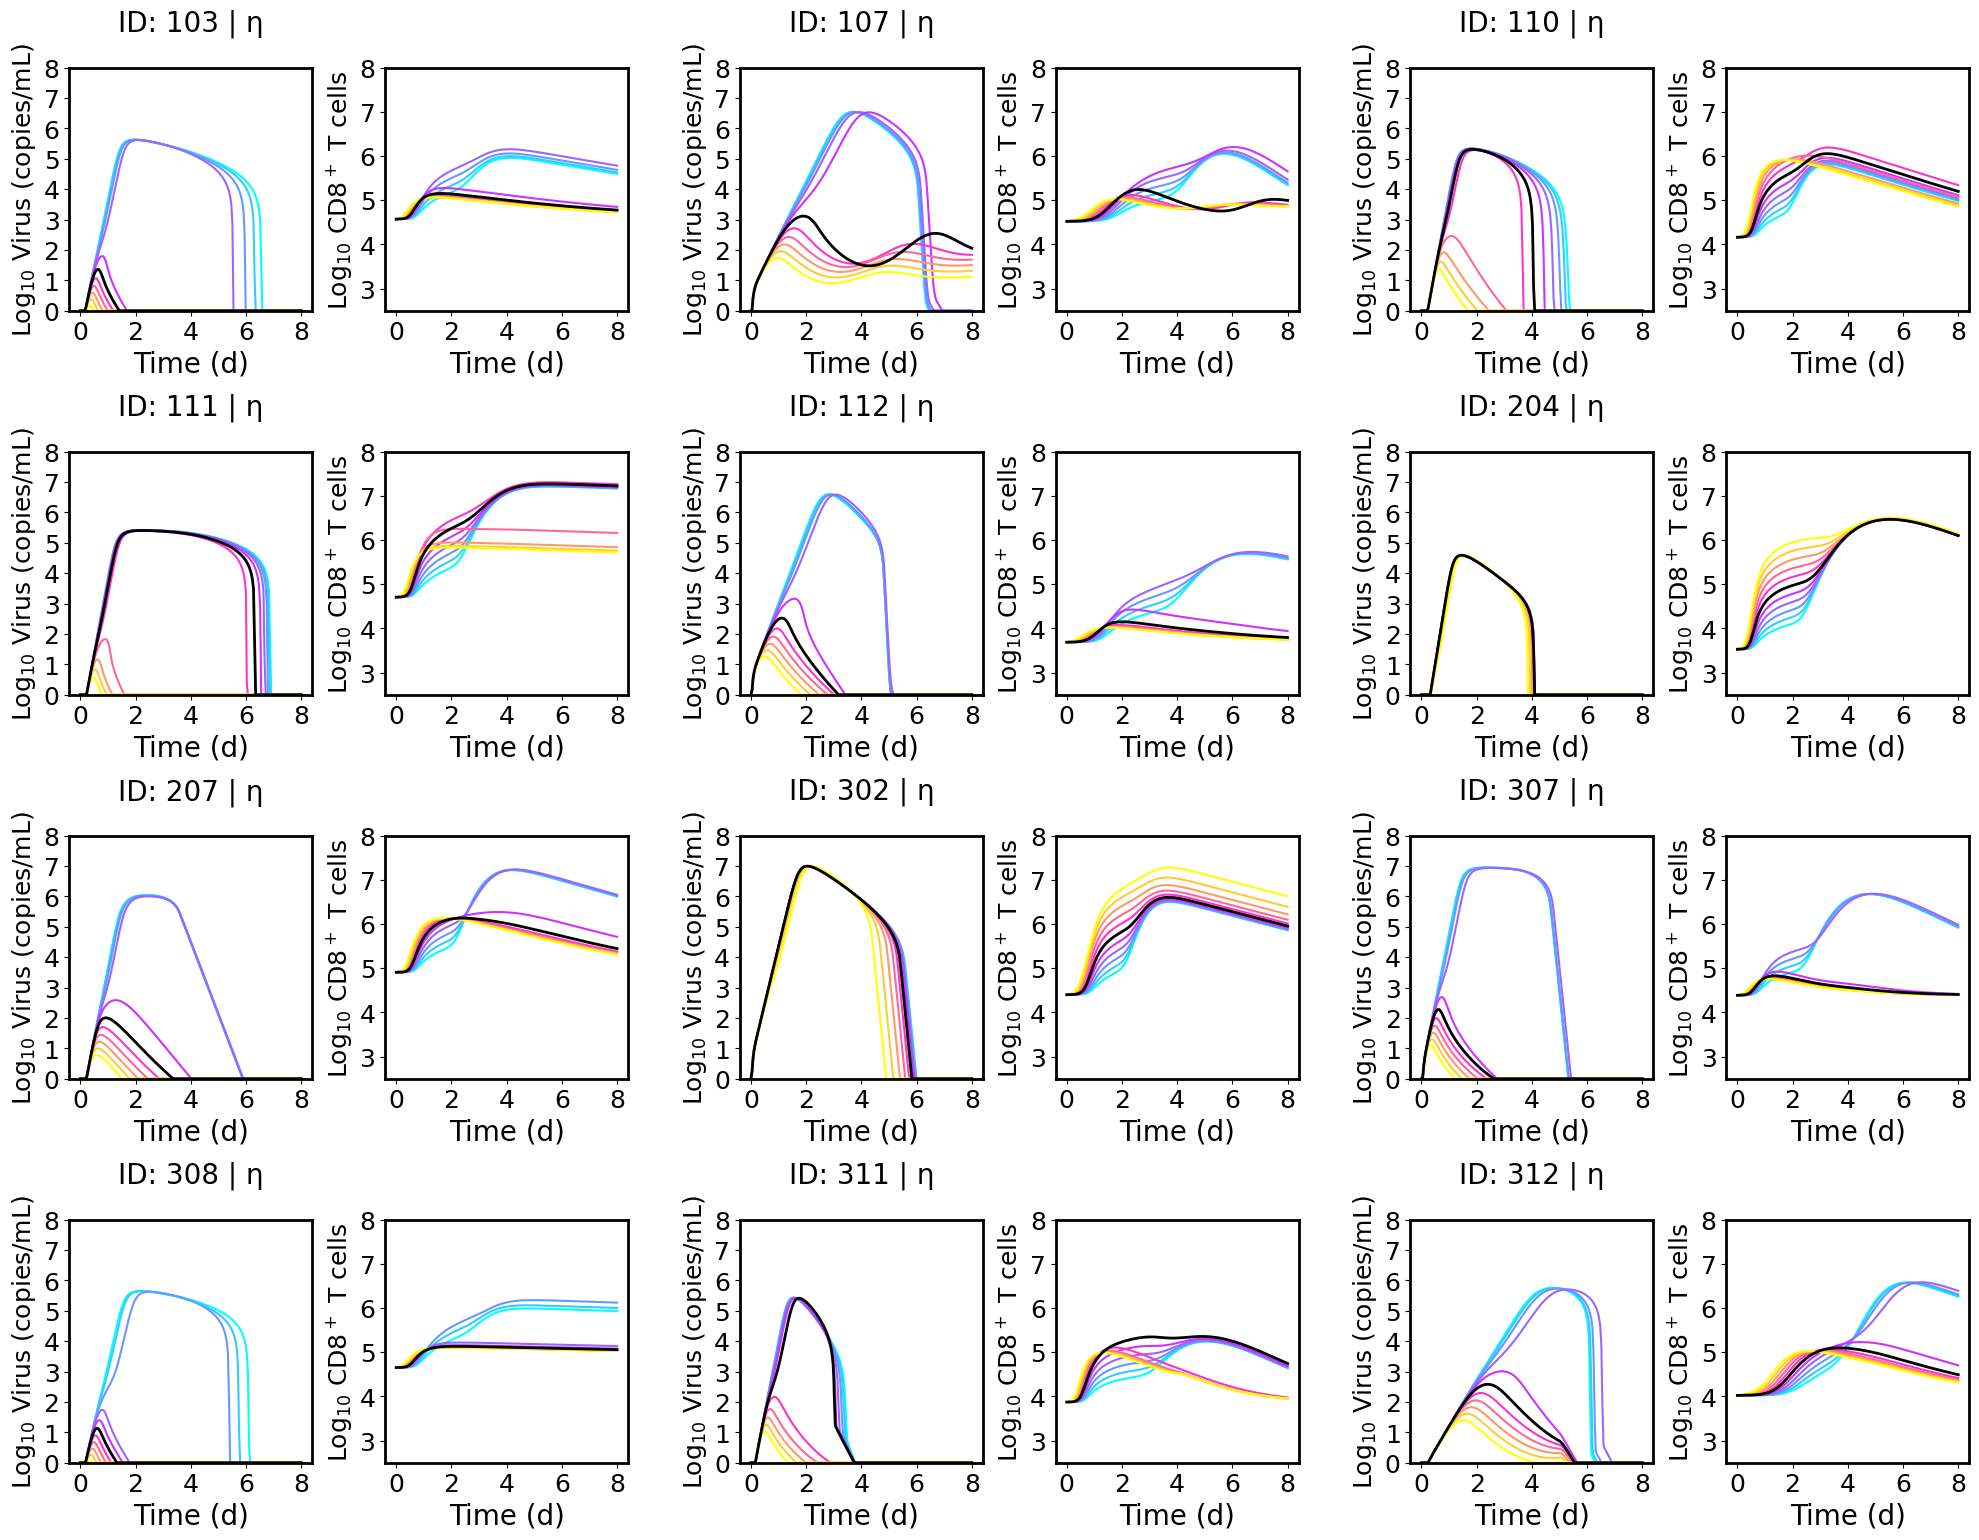

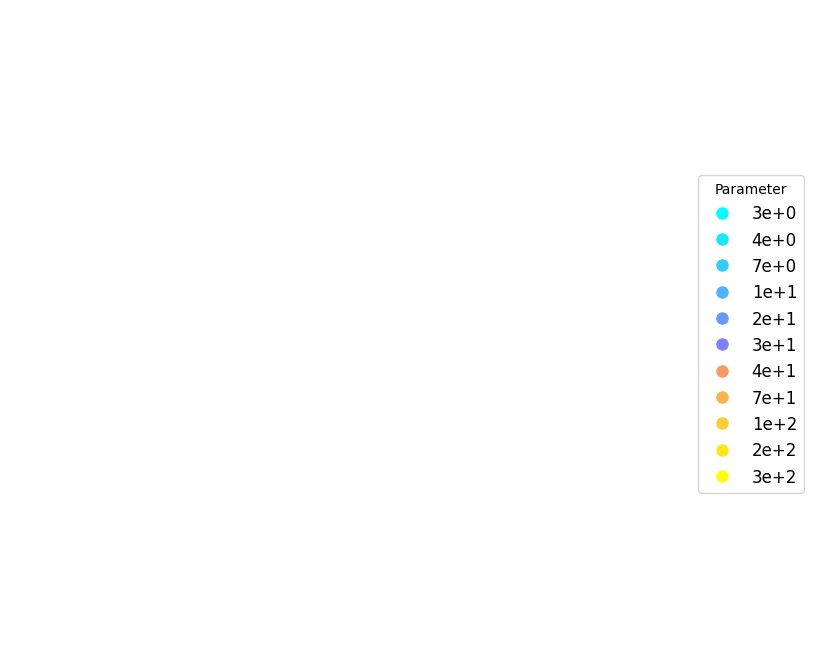

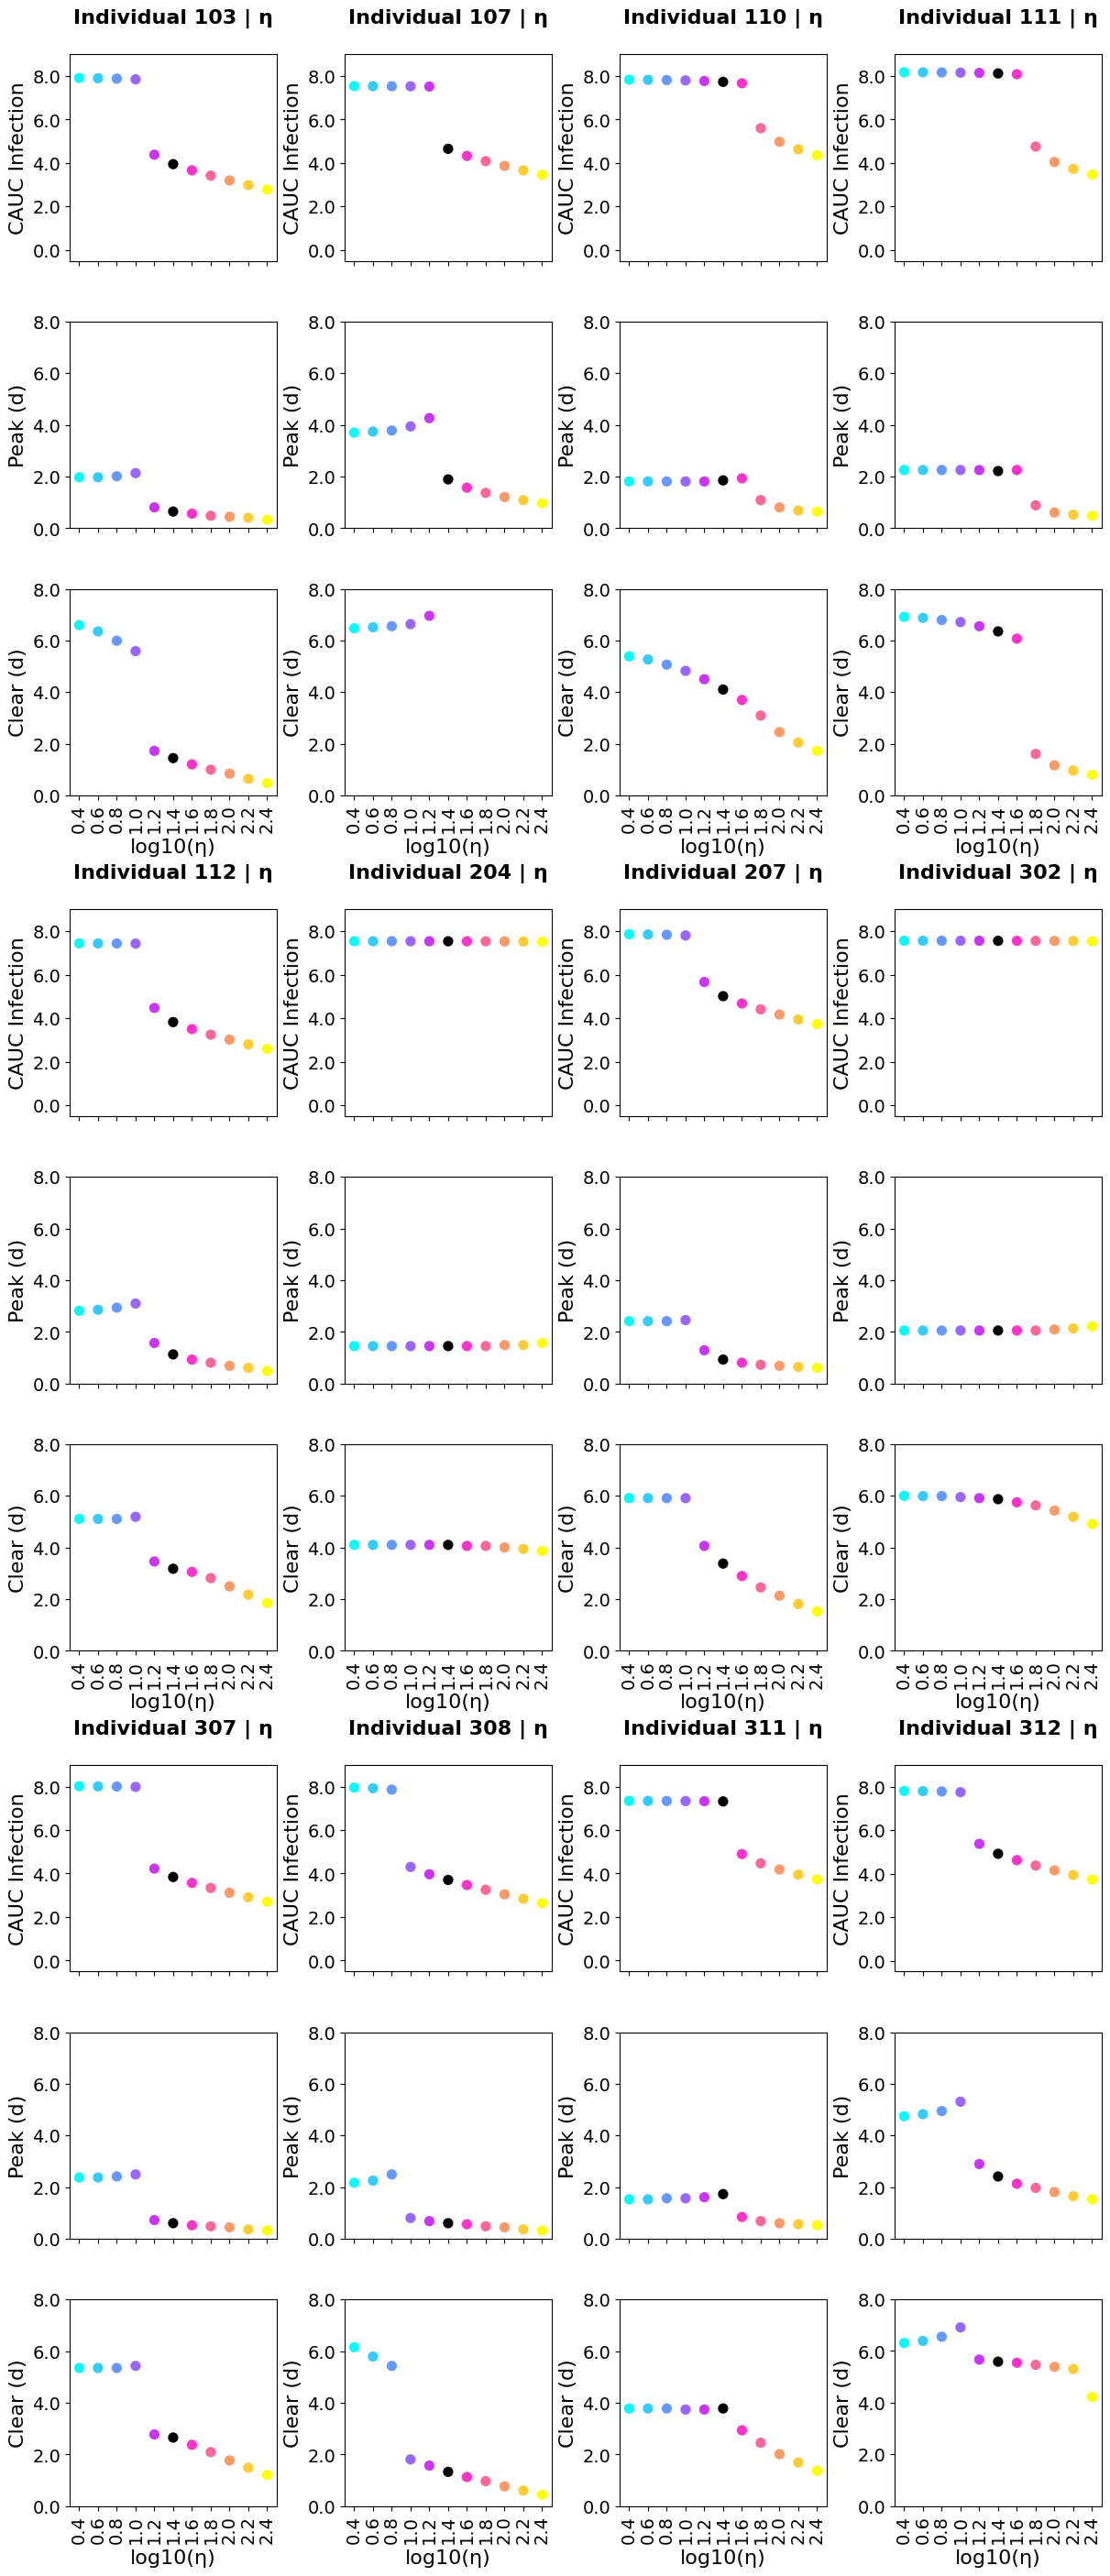

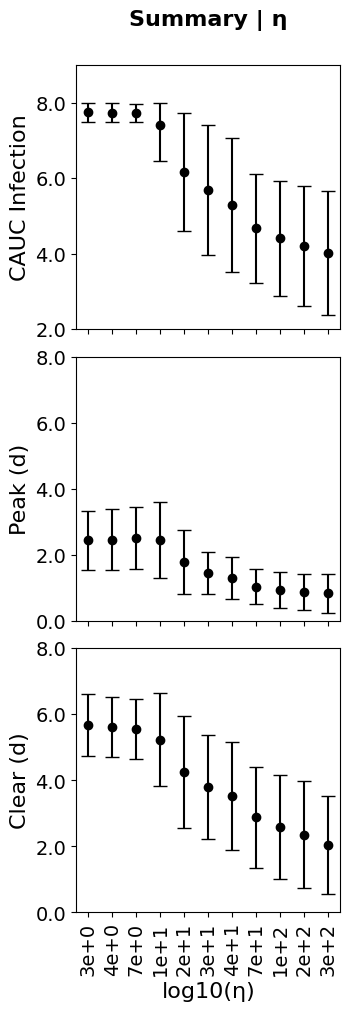

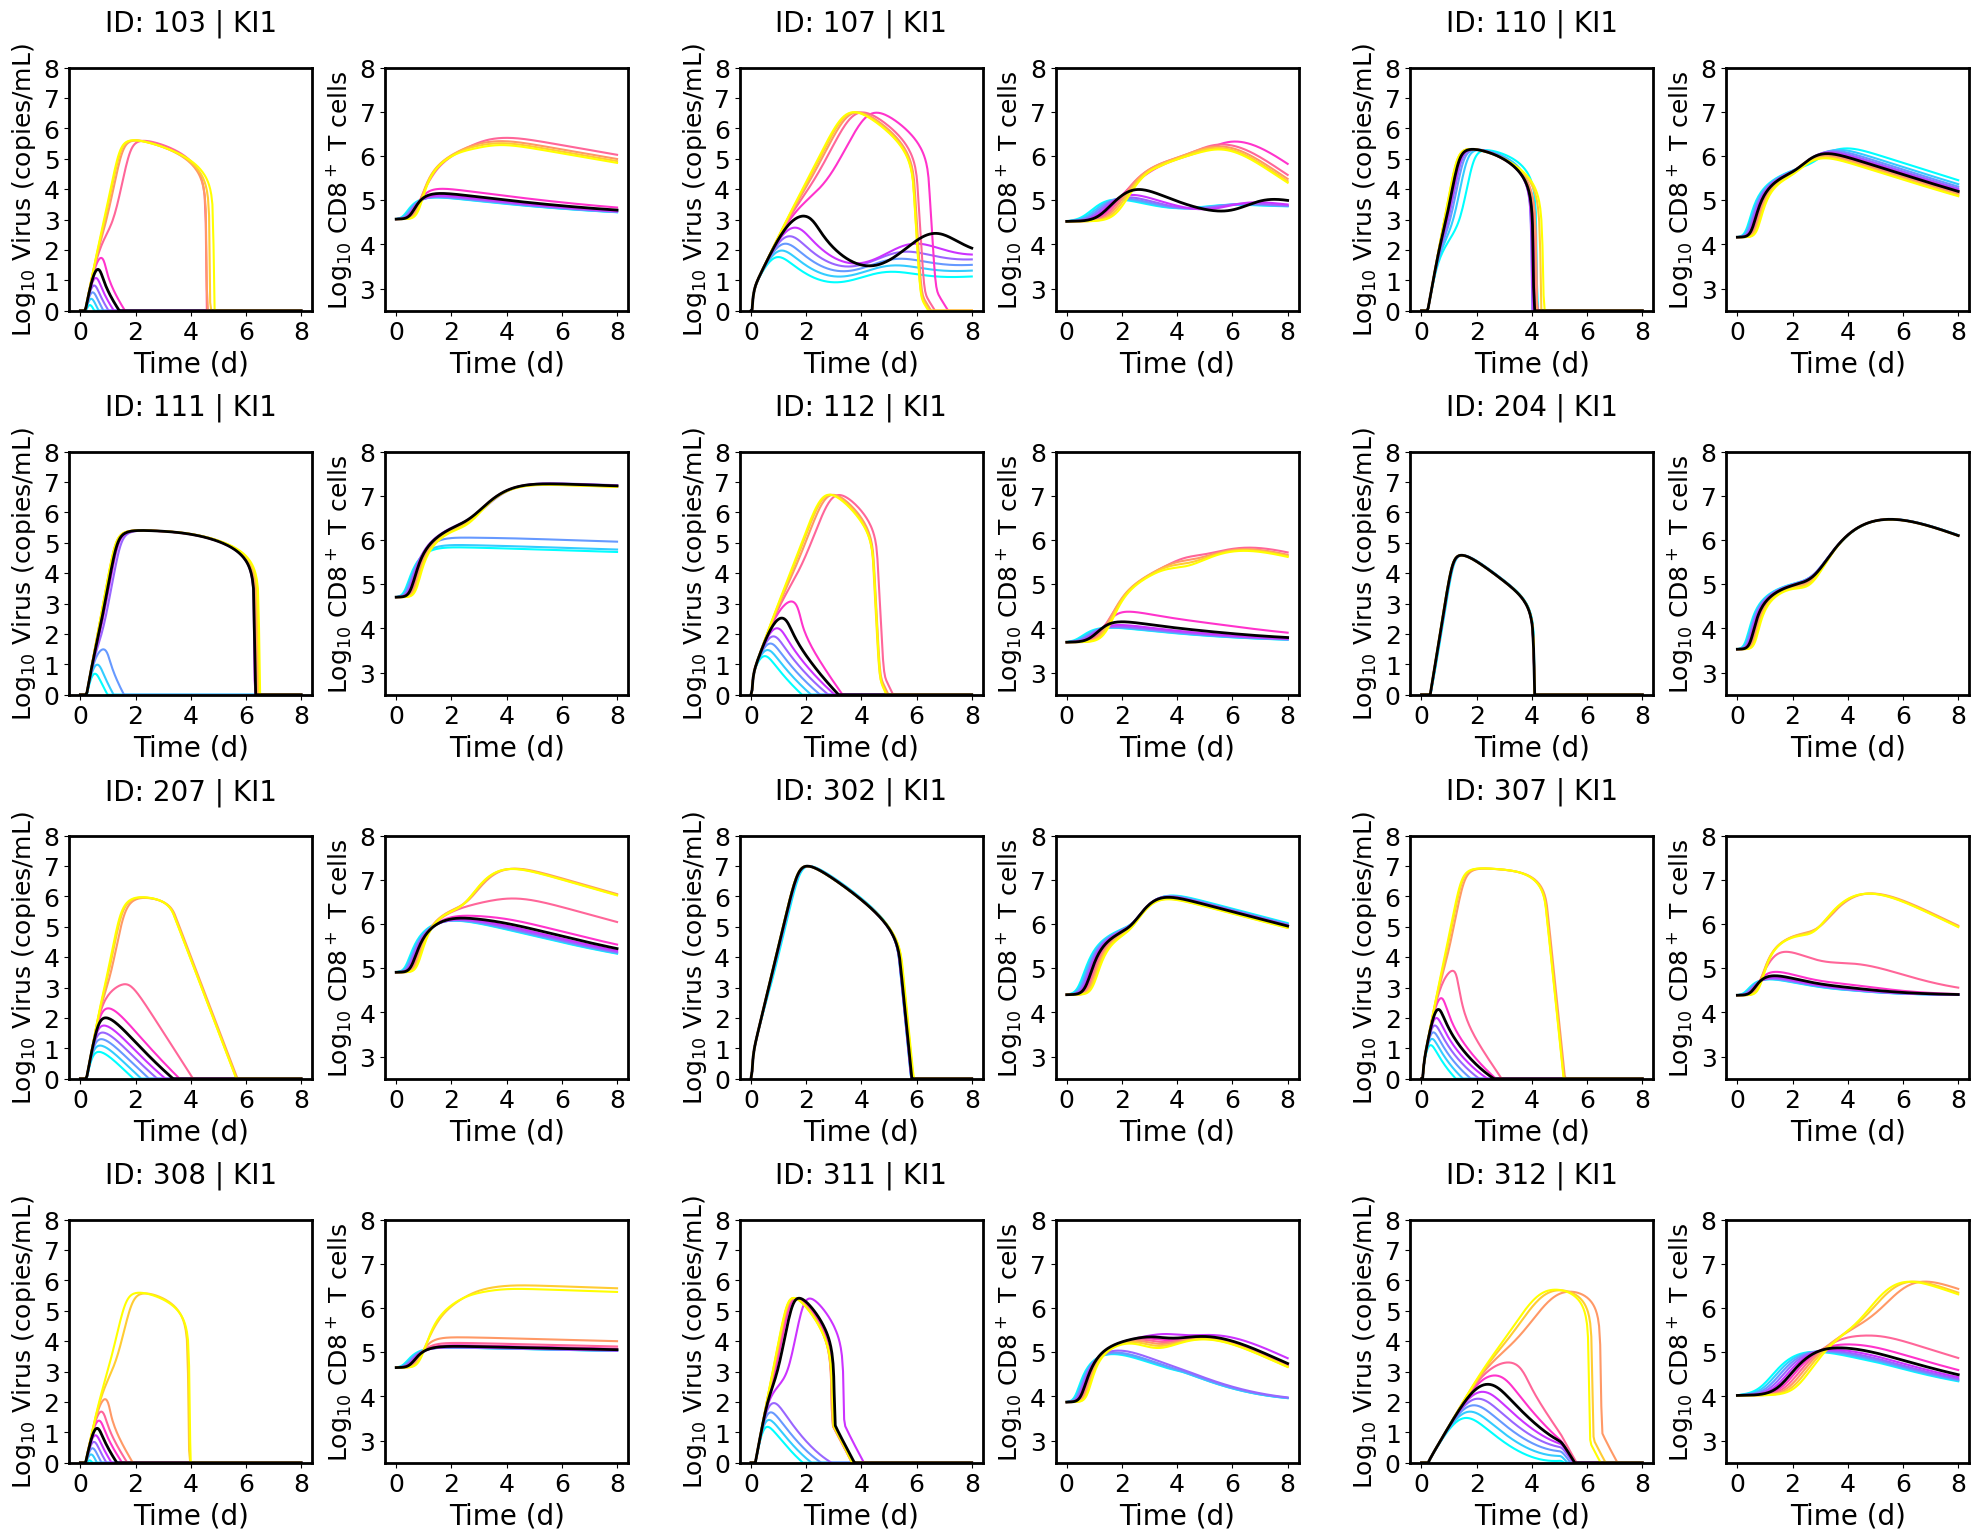

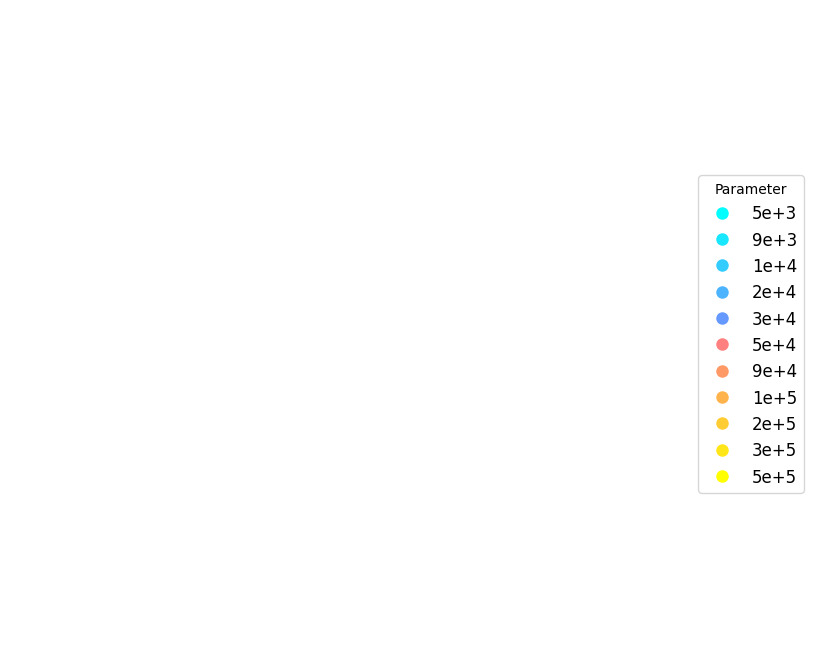

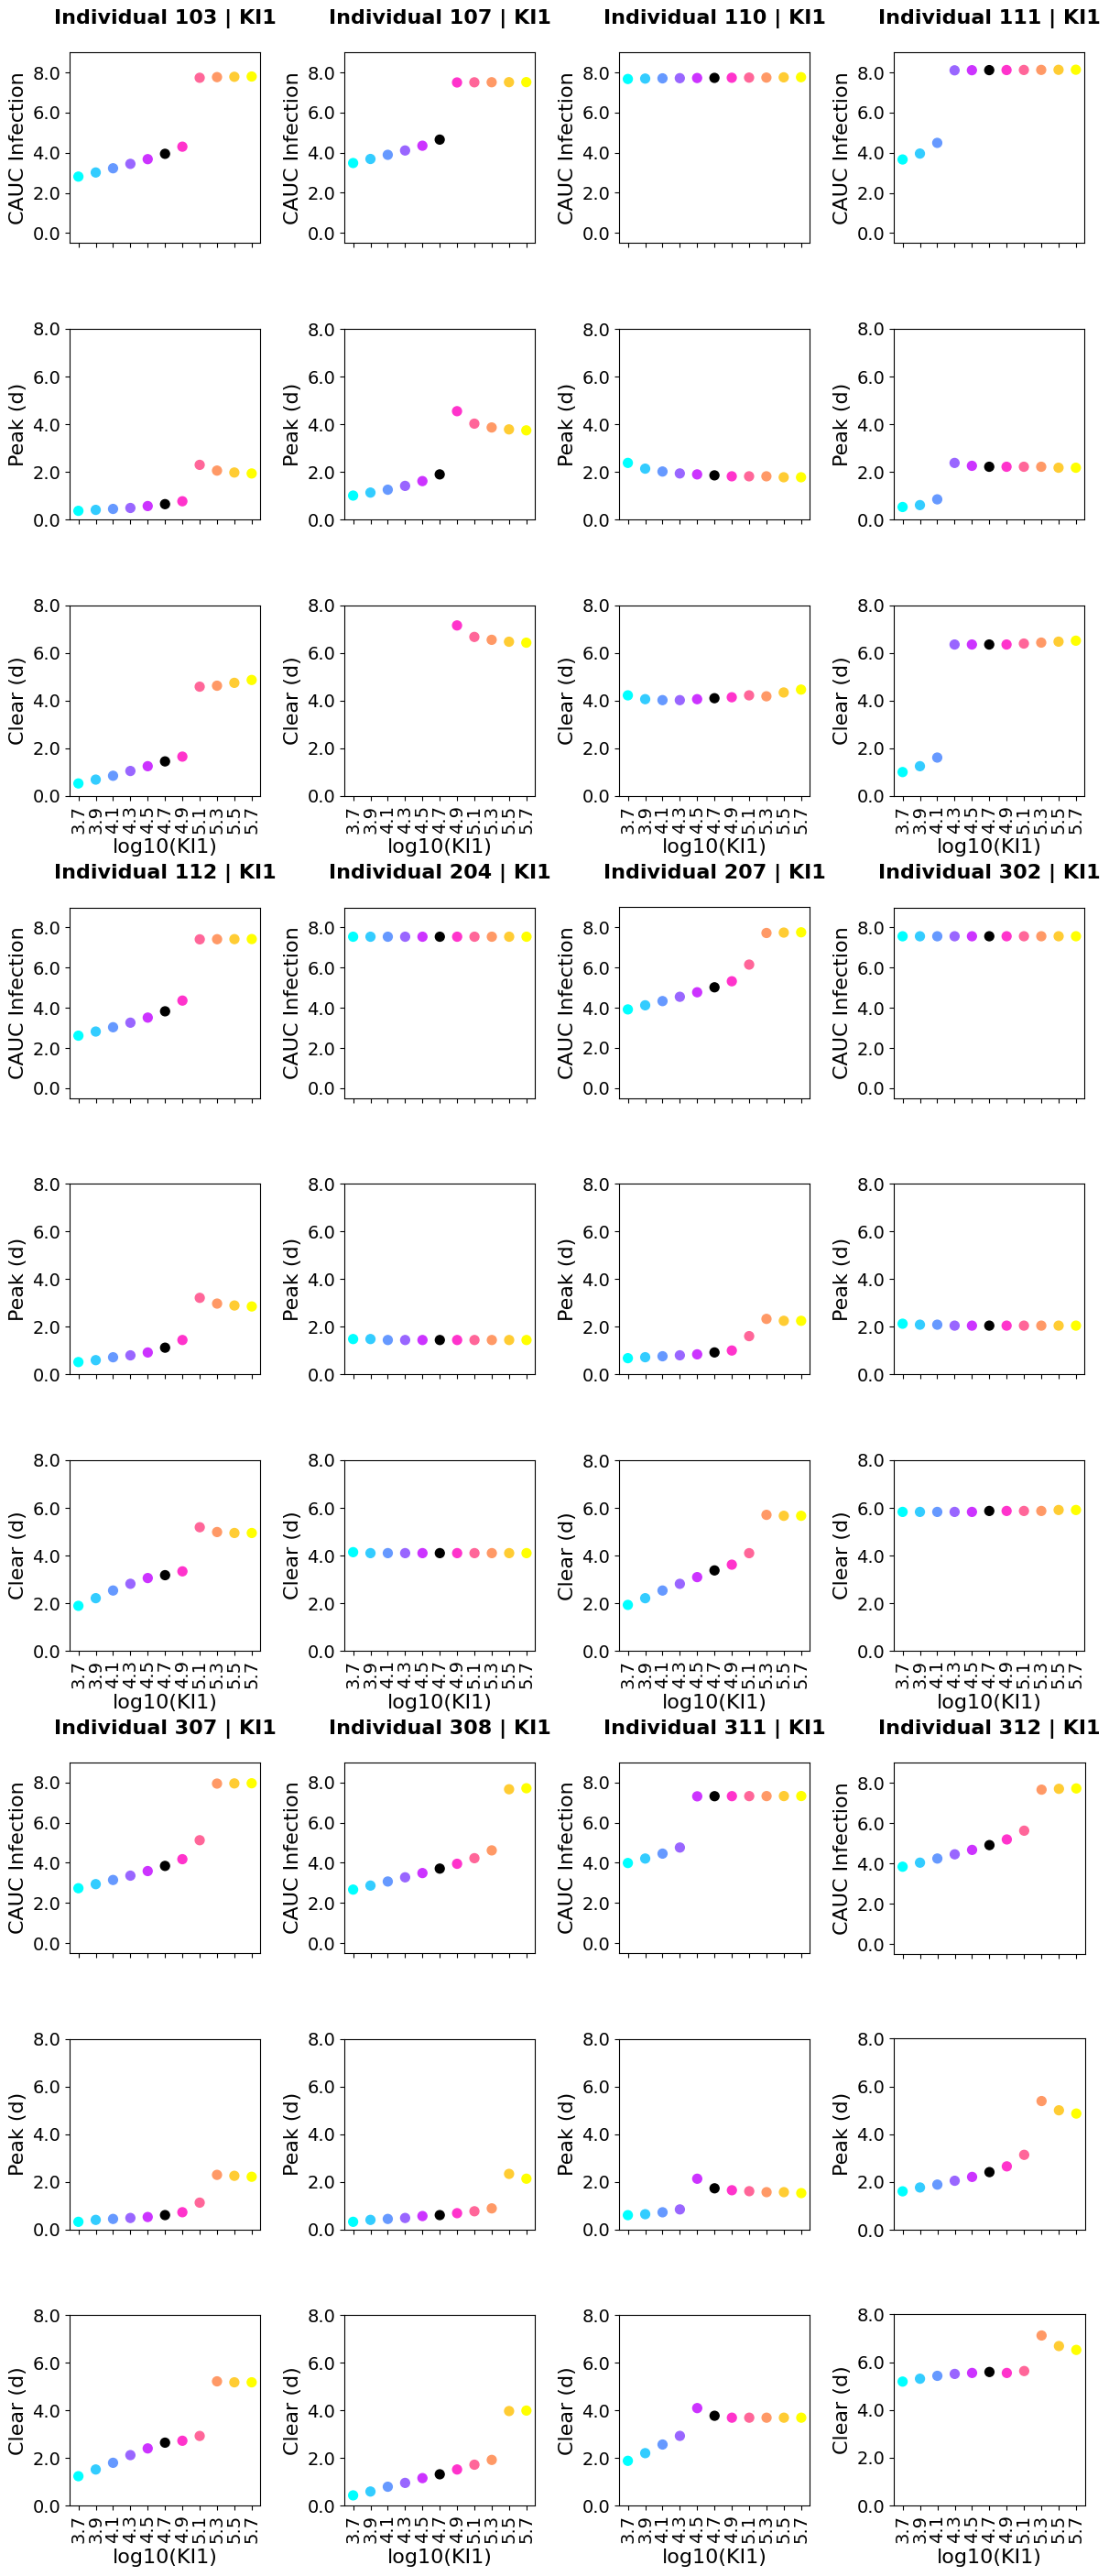

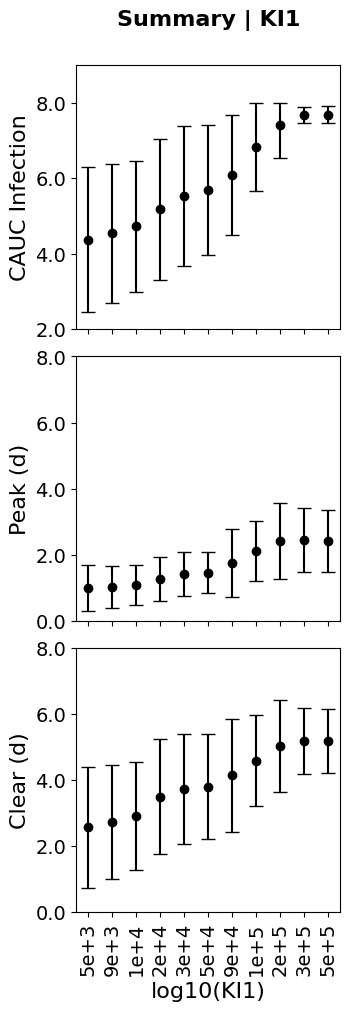

In [16]:
import os
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.colors as mcolors
import matplotlib.gridspec as gridspec
from matplotlib.lines import Line2D

try:
    get_ipython().run_line_magic('load_ext', 'autoreload')
    get_ipython().run_line_magic('autoreload', '2')
except Exception as e:
    pass

os.environ["JULIA_NUM_THREADS"] = "4"
from julia.api import Julia
julia = Julia(sysimage="../sysimage_env/sysimage.so")
from julia import Main
Main.include("../models/Primary_model.jl")
Main.include("../models/Reinfection_model.jl") 

from goose import sci_format, format_fit_params, read_excel


def run_simulation(t_span, y0, base_params, sweep_param, percent=None, log=None):
    base_value = base_params[sweep_param]
    n_points = 11 
    if percent is not None and log is None:
        sweep_range = (base_value * (1 - percent/100), base_value * (1 + percent/100))
        sweep_values = np.linspace(sweep_range[0], sweep_range[1], n_points)
    elif log is not None and percent is None:
        sweep_range = (base_value * (10 ** -log), base_value * (10 ** log))
        sweep_values = 10 ** np.linspace(np.log10(sweep_range[0]), np.log10(sweep_range[1]), n_points)
    else:
        raise ValueError("Either percent or log must be provided exclusively.")
        
    # Prepare a constant y0 for all simulations (using base T0 and ME)
    y0_sim = y0.copy()
    y0_sim[0] = base_params["T0"]
    y0_sim[5] = Zero_conditions["ME"]
    y0_sim = [float(x) for x in y0_sim]
    
    param_order = ["beta", "k", "p", "c", "delta", "xi", "a", 
                   "d_E", "delta_E", "K_delta_E", "zeta", "eta", "K_I1", 
                   "tau_memory", "damp"]
    
    # Build a batch (list) of parameter sets for all sweep values.
    # For each run, we start with the base parameters (excluding T0 and ME)
    # and then override the swept parameter.
    param_sets = []
    for value in sweep_values:
        params = {k: base_params[k] for k in base_params if k not in ["T0", "ME"]}
        params[sweep_param] = value
        param_set = [float(np.float64(params[key])) for key in param_order]
        param_sets.append(param_set)
    
    # *** Convert each parameter set to a native Julia Vector{Float64} ***
    # This forces PyCall to recognize each inner list as an AbstractVector.
    # Here we build a Julia array literal string (e.g., "[1.0,2.0,...]") and evaluate it.
    param_sets = [Main.eval("[" + ",".join(map(str, p)) + "]") for p in param_sets]
        
    t_fill = np.linspace(t_span[0], t_span[-1], 200)
    t_int = np.arange(t_span[0], t_span[-1] + 1)
    t_span = np.unique(np.concatenate([t_span, t_fill, t_int]))
    # Run all simulations in parallel (ThreadsX is used inside Julia)
    results = Main.tmap_ReinfectionModel(t_span, y0_sim, param_sets)
    
    # Convert the Julia results into a list of dictionaries with numpy arrays
    solutions = []
    for res in results:
        t_values = np.array(res[0], dtype=np.float64)
        y_values = np.array(res[1], dtype=np.float64)
        #print('sol shape:',np.shape(y_values))
        solutions.append({"t": t_values, "y": y_values})
    
    # Compute key metrics: cumulative infection (CAUC), time of peak virus, and clearance day.
    cauc_values, peak_days, clear_days = [], [], []
    for sol in solutions:
        t_arr = sol["t"]
        virus = sol["y"][3, :]
        infection = sol["y"][1, :] + sol["y"][2, :]
        auc = np.trapezoid(infection, t_arr)
        cauc_values.append(auc)
        peak_idx = np.argmax(virus)
        peak_days.append(t_arr[peak_idx])
        clear_time = np.nan
        for i in range(peak_idx+1, len(t_arr)):
            if virus[i] < 1:
                clear_time = t_arr[i]
                break
        clear_days.append(clear_time)
        
    # Run a baseline simulation (with unswept base parameters)
    baseline_params = {k: base_params[k] for k in base_params if k not in ["T0", "ME"]}
    baseline_param_set = [float(np.float64(baseline_params[key])) for key in param_order]
    # Convert baseline_param_set to a native Julia vector
    baseline_param_set = Main.eval("[" + ",".join(map(str, baseline_param_set)) + "]")
    
    baseline_y0 = y0.copy()
    baseline_y0[0] = base_params["T0"]
    baseline_y0[5] = Zero_conditions["ME"]
    baseline_y0 = [float(x) for x in baseline_y0]
    baseline_result = Main.tmap_ReinfectionModel(t_span, baseline_y0, baseline_param_set)
    # Since tmap_ReinfectionModel wraps a single set in a list, extract the first element
    baseline_tuple = baseline_result[0]
    baseline = {"t": np.array(baseline_tuple[0], dtype=np.float64),
                "y": np.array(baseline_tuple[1], dtype=np.float64)}
                
    if log is not None:
        subset_tick_values = 10 ** np.linspace(np.log10(sweep_range[0]), np.log10(sweep_range[1]), 11)
    else:
        subset_tick_values = np.linspace(sweep_range[0], sweep_range[1], 11)
        
    dynamics_indices = []
    for tick in subset_tick_values:
        if np.isclose(tick, base_value):
            continue
        idx = np.argmin(np.abs(sweep_values - tick))
        dynamics_indices.append(idx)
    dynamics_indices = np.array(dynamics_indices)
    
    return {
        "sweep_values": sweep_values,
        "solutions": solutions,
        "baseline": baseline,
        "cauc_values": np.array(cauc_values),
        "peak_days": np.array(peak_days),
        "clear_days": np.array(clear_days),
        "subset_tick_values": subset_tick_values,
        "dynamics_indices": dynamics_indices,
        "base_value": base_value,
        "sweep_range": sweep_range
    }

def plot_individual_dynamics(fig, cell_gs, sim_data, t_span, Zero_conditions, sweep_param, indiv_id, log):
    """
    In a given cell (a SubplotSpec), plot the virus and effector dynamics for one individual.
    """
    gs_dyn = mpl.gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=cell_gs, wspace=0.3)
    ax_virus = fig.add_subplot(gs_dyn[0])
    ax_effector = fig.add_subplot(gs_dyn[1])

    for spine in ax_virus.spines.values():
        spine.set_color('black')
        spine.set_linewidth(2)
    for spine in ax_effector.spines.values():
        spine.set_color('black')
        spine.set_linewidth(2)

    base_value = sim_data["base_value"]
    sweep_values = sim_data["sweep_values"]
    solutions = sim_data["solutions"]
    subset_tick_values = sim_data["subset_tick_values"]
    dynamics_indices = sim_data["dynamics_indices"]

    cmap_decrease = plt.get_cmap("cool")
    cmap_increase = plt.get_cmap("spring")
    if log is not None:
        norm_decrease = mpl.colors.LogNorm(vmin=sweep_values[0], vmax=base_value)
        norm_increase = mpl.colors.LogNorm(vmin=base_value, vmax=sweep_values[-1])
    else:
        norm_decrease = mpl.colors.Normalize(vmin=sweep_values[0], vmax=base_value)
        norm_increase = mpl.colors.Normalize(vmin=base_value, vmax=sweep_values[-1])

    for idx in dynamics_indices:
        val = sweep_values[idx]
        color = cmap_decrease(norm_decrease(val)) if val < base_value else cmap_increase(norm_increase(val))
        sol = solutions[idx]
        ax_virus.plot(sol["t"], np.log10(np.maximum(sol["y"][3, :], 1)), color=color, linewidth=1.5)
        ax_effector.plot(sol["t"], np.log10(np.maximum(sol["y"][4, :] + sol["y"][5, 0], 1)), color=color, linewidth=1.5)

    # Plot the baseline simulation in black.
    baseline = sim_data["baseline"]
    ax_virus.plot(baseline["t"], np.log10(np.maximum(baseline["y"][3, :], 1)), color='black', linewidth=2)
    ax_effector.plot(baseline["t"], np.log10(np.maximum(baseline["y"][4, :] + Zero_conditions["ME"], 1)),
                     color='black', linewidth=2)

    ax_virus.set_yticks(np.arange(0, 9, 1))
    ax_effector.set_yticks(np.arange(2, 9, 1))
    ax_virus.set_xticks([0, 2, 4, 6, 8])
    ax_effector.set_xticks([0, 2, 4, 6, 8])
    ax_virus.set_ylabel('Log$_{10}$ Virus (copies/mL)', fontsize=18)
    ax_effector.set_ylabel('Log$_{10}$ CD8$^+$ T cells', fontsize=18)
    ax_virus.set_xlabel("Time (d)", fontsize=20)
    ax_effector.set_xlabel("Time (d)", fontsize=20)
    ax_virus.tick_params(labelsize=18)
    ax_effector.tick_params(labelsize=18)
    ax_virus.set_ylim(0, 8)
    ax_effector.set_ylim(2.5, 8)
    ax_virus.set_box_aspect(1)
    ax_effector.set_box_aspect(1)
    ax_virus.text(0.5, 1.15, f"ID: {indiv_id} | {format_fit_params(sweep_param)}",
                  transform=ax_virus.transAxes, fontsize=20, ha='center')
    
    plt.savefig(f'../plots/sensitivity/parameter/{indiv_id}_dynamics_{format_fit_params(sweep_param)}.svg', format='svg', bbox_inches='tight')

def create_global_legend(fig, rep_sim, log):
    rep_sweep = rep_sim["sweep_values"]
    rep_base = rep_sim["base_value"]
    cmap_decrease = plt.get_cmap("cool")
    cmap_increase = plt.get_cmap("spring")
    
    # Define the normalization based on log scale or linear scale
    if log is not None:
        global_norm = mpl.colors.LogNorm(vmin=rep_sweep.min(), vmax=rep_sweep.max())
    else:
        global_norm = mpl.colors.Normalize(vmin=rep_sweep.min(), vmax=rep_sweep.max())

    subset_ticks = rep_sim["subset_tick_values"]

    # Create a discrete color map by mapping each tick to a color
    tick_colors = [cmap_decrease(global_norm(val)) if val < rep_base else cmap_increase(global_norm(val)) 
                   for val in subset_ticks]

    # Create legend entries
    legend_elements = [mpl.lines.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, 
                                        markersize=10, label=f"{sci_format(val, None)}")
                       for val, color in zip(subset_ticks, tick_colors)]

    # Ensure there's at least one axis so the figure can display
    ax = fig.add_subplot(111)
    ax.axis("off")  # Hide the dummy axis

    # Add legend to the figure
    ax.legend(handles=legend_elements, title="Parameter", loc="center left", bbox_to_anchor=(0.85, 0.5), fontsize=12)

def plot_individual_metrics(fig, cell_gs, sim_data, sweep_param, indiv_id, log, ylims_auc, ylims_peak, ylims_clear):
    gs_met = gridspec.GridSpecFromSubplotSpec(3, 1, subplot_spec=cell_gs, hspace=0)
    ax_auc   = fig.add_subplot(gs_met[0])
    ax_peak  = fig.add_subplot(gs_met[1], sharex=ax_auc)
    ax_clear = fig.add_subplot(gs_met[2], sharex=ax_auc)
    
    plt.setp(ax_auc.get_xticklabels(), visible=False)
    plt.setp(ax_peak.get_xticklabels(), visible=False)
    
    if log is not None:
        x_metric = np.log10(sim_data["sweep_values"])
        subset_x = np.log10(sim_data["subset_tick_values"])
    else:
        x_metric = sim_data["sweep_values"]
        subset_x = sim_data["subset_tick_values"]
    
    cmap_decrease = plt.get_cmap("cool")
    cmap_increase = plt.get_cmap("spring")
    base_value = sim_data["base_value"]
    
    if log is not None:
        norm_decrease = mpl.colors.LogNorm(vmin=sim_data["sweep_values"][0], vmax=base_value)
        norm_increase = mpl.colors.LogNorm(vmin=base_value, vmax=sim_data["sweep_values"][-1])
    else:
        norm_decrease = mpl.colors.Normalize(vmin=sim_data["sweep_values"][0], vmax=base_value)
        norm_increase = mpl.colors.Normalize(vmin=base_value, vmax=sim_data["sweep_values"][-1])
    
    marker_colors = []
    for tick in sim_data["subset_tick_values"]:
        if np.isclose(tick, base_value):
            marker_colors.append('black')
        else:
            marker_colors.append(cmap_decrease(norm_decrease(tick)) if tick < base_value else cmap_increase(norm_increase(tick)))
    
    # Plot each metric
    for ax, metric, label in zip([ax_auc, ax_peak, ax_clear],
                                 [np.log10(sim_data["cauc_values"]), sim_data["peak_days"], sim_data["clear_days"]],
                                 ["CAUC Infection", "Peak Day", "Clear Day"]):
        marker_vals = [metric[np.argmin(np.abs(sim_data["sweep_values"] - tick))] 
                       for tick in sim_data["subset_tick_values"]]
        ax.scatter(subset_x, marker_vals, color=marker_colors, zorder=5, s=50)
    
    ax_clear.set_xlabel(f"log10({format_fit_params(sweep_param)})", fontsize=16)
    ax_clear.set_xticks(subset_x)
    ax_clear.set_xticklabels([f"{np.log10(val):.1f}" for val in sim_data["subset_tick_values"]], fontsize=14, rotation=90)
    ax_auc.set_ylim(-0.5,9)
    ax_peak.set_ylim(0,8)
    ax_clear.set_ylim(0,8)
    for ax in [ax_auc, ax_peak, ax_clear]:
        ax.set_box_aspect(1)
        ax.tick_params(axis='x', labelsize=14)
        ax.tick_params(axis='y', labelsize=14)
    ax_auc.yaxis.set_major_formatter(mpl.ticker.FormatStrFormatter('%.1f'))
    ax_peak.yaxis.set_major_formatter(mpl.ticker.FormatStrFormatter('%.1f'))
    ax_clear.yaxis.set_major_formatter(mpl.ticker.FormatStrFormatter('%.1f'))
    ax_auc.set_ylabel('CAUC Infection', fontsize=16)
    ax_peak.set_ylabel("Peak (d)", fontsize=16)
    ax_clear.set_ylabel("Clear (d)", fontsize=16)
    ax_auc.text(0.5, 1.15, f"Individual {indiv_id} | {format_fit_params(sweep_param)}", 
                transform=ax_auc.transAxes, fontsize=16, ha='center', fontweight='bold')
    
    plt.savefig(f'../plots/sensitivity/parameter/individual_metrics_{format_fit_params(sweep_param)}.svg', format='svg', bbox_inches='tight')

def plot_summary_metrics(fig, cell_gs, sim_data_list, sweep_param, log, ylims_auc, ylims_peak, ylims_clear):
    gs_met = gridspec.GridSpecFromSubplotSpec(3, 1, subplot_spec=cell_gs, hspace=0)
    ax_auc   = fig.add_subplot(gs_met[0])
    ax_peak  = fig.add_subplot(gs_met[1], sharex=ax_auc)
    ax_clear = fig.add_subplot(gs_met[2], sharex=ax_auc)
    
    plt.setp(ax_auc.get_xticklabels(), visible=False)
    plt.setp(ax_peak.get_xticklabels(), visible=False)
    
    # Use the first individual's data for x-axis info and base_value
    base_data = sim_data_list[0]
    if log is not None:
        x_metric = np.log10(base_data["sweep_values"])
        subset_x = np.log10(base_data["subset_tick_values"])
    else:
        x_metric = base_data["sweep_values"]
        subset_x = base_data["subset_tick_values"]
    
    cmap_decrease = plt.get_cmap("cool")
    cmap_increase = plt.get_cmap("spring")
    base_value = base_data["base_value"]
    
    if log is not None:
        norm_decrease = mpl.colors.LogNorm(vmin=base_data["sweep_values"][0], vmax=base_value)
        norm_increase = mpl.colors.LogNorm(vmin=base_data["sweep_values"][0], vmax=base_value)
    else:
        norm_decrease = mpl.colors.Normalize(vmin=base_data["sweep_values"][0], vmax=base_value)
        norm_increase = mpl.colors.Normalize(vmin=base_data["sweep_values"][0], vmax=base_value)
    
    marker_colors = []
    for tick in base_data["subset_tick_values"]:
        if np.isclose(tick, base_value):
            marker_colors.append('black')
        else:
            marker_colors.append(cmap_decrease(norm_decrease(tick)) if tick < base_value else cmap_increase(norm_increase(tick)))
    
    # Define functions to extract the metric values.
    # For CAUC, we use np.log10 of the individual’s cauc_values.
    metric_funcs = [
        lambda d: np.log10(d["cauc_values"]),
        lambda d: d["peak_days"],
        lambda d: d["clear_days"]
    ]
    ylabels = ['CAUC Infection', 'Peak (d)', 'Clear (d)']
    
    # Loop over each metric axis (auc, peak, clear)
    for ax, metric_func, ylabel in zip([ax_auc, ax_peak, ax_clear], metric_funcs, ylabels):
        means = []
        stds = []
        # For each parameter tick (the same across individuals)
        for tick in base_data["subset_tick_values"]:
            # For each individual, get the value corresponding to the tick (using the closest index)
            vals = []
            for sim_data in sim_data_list:
                idx = np.argmin(np.abs(sim_data["sweep_values"] - tick))
                val = metric_func(sim_data)[idx]
                if np.isfinite(val):  # Check if the value is finite (not NaN or inf)
                    vals.append(val)
            vals = np.array(vals)
            if len(vals) > 0:  # Ensure there are valid values to calculate mean and std
                means.append(np.mean(vals))
                stds.append(np.std(vals))
            else:
                means.append(np.nan)  # Append NaN if no valid values
                stds.append(np.nan)   # Append NaN if no valid values
        means = np.array(means)
        stds = np.array(stds)
        
        # If mean - std < 0, adjust std so mean-std = 0
        lower_err = np.minimum(means, stds)

        # If mean + std > 8, adjust std so mean+std = 8
        upper_err = np.minimum(8 - means, stds)

        # Stack errors for error bars
        yerr = np.vstack([lower_err, upper_err])

        yerr = np.vstack([lower_err, upper_err])
        # Plot with errorbar: marker at the mean with vertical error bars.
        ax.errorbar(subset_x, means, yerr=yerr, fmt='o', color='black', ecolor='black', capsize=5, zorder=5)
        ax.set_ylabel(ylabel, fontsize=16)
    
    ax_clear.set_xlabel(f"log10({format_fit_params(sweep_param)})", fontsize=16)
    ax_clear.set_xticks(subset_x)
    ax_clear.set_xticklabels([f"{np.log10(val):.1f}" for val in base_data["subset_tick_values"]], fontsize=14, rotation=90)
    ax_auc.set_ylim(2,9)
    ax_peak.set_ylim(0,8)
    ax_clear.set_ylim(0,8)
    for ax in [ax_auc, ax_peak, ax_clear]:
        ax.set_box_aspect(1)
        ax.tick_params(axis='x', labelsize=14)
        ax.tick_params(axis='y', labelsize=14)
    ax_auc.yaxis.set_major_formatter(mpl.ticker.FormatStrFormatter('%.1f'))
    ax_peak.yaxis.set_major_formatter(mpl.ticker.FormatStrFormatter('%.1f'))
    ax_clear.yaxis.set_major_formatter(mpl.ticker.FormatStrFormatter('%.1f'))
    
    # Format x ticks using sci_format
    for ax in [ax_auc, ax_peak, ax_clear]:
        ax.set_xticklabels([sci_format(10**val, None) for val in ax.get_xticks()], fontsize=14, rotation=90)
    ax_auc.text(0.5, 1.15, f"Summary | {format_fit_params(sweep_param)}", 
                transform=ax_auc.transAxes, fontsize=16, ha='center', fontweight='bold')
    
    plt.savefig(f'../plots/sensitivity/parameter/summary_metrics_{format_fit_params(sweep_param)}.svg', format='svg', bbox_inches='tight')
    
params = read_excel("../parameters/Reinfection.xlsx")
ids = params[params['id'] != 'Population']['id'].unique() 

patient_color_names = ['gray', 'purple', 'magenta', 'red', 'goldenrod', 'darkorange',
                        'saddlebrown', 'mediumblue', 'dodgerblue', 'turquoise', 'darkgreen', 'lawngreen']
patient_colors = {}
for pid, cname in zip(ids, patient_color_names):
    rgba = mcolors.to_rgba(cname)
    patient_colors[pid] = {'matplotlib': rgba, 'plotly': mpl.colors.to_hex(rgba, keep_alpha=False)}

df_Rahil = read_excel("../data/Rahil2020_Table8.xlsx")
df_Rahil = df_Rahil[['VOLUNTEER', 'DAY', 'V', 'TSS', 'CD8TE', 'CD8TM', 'COHORT']]
df_Rahil = df_Rahil[(df_Rahil['DAY'] < 9) & (df_Rahil['DAY'] > -0.01)]
df_Rahil = df_Rahil[df_Rahil['VOLUNTEER'].isin(ids)]

t_span = (0.0, 8)
y0_master = [0, 75.0, 0.0, 0.0, 0.0, 0.0] + [0.0]*13

percent = 50
log = 1
swept_params = ["eta", "K_I1"]

sim_data_dict = {}
all_auc, all_peak, all_clear = [], [], []
for sweep_param in swept_params:
    for indiv_id in ids:
        row = params[params['id'] == indiv_id].iloc[0]
        base_params = {
            "T0": row['T0'],
            "beta": row['beta'],
            "k": row['k'],
            "p": row['p'],
            "c": row['c'],
            "delta": row['delta'],
            "xi": row['xi'],
            "a": row['a'],
            "d_E": row['d_E'],
            "delta_E": row['delta_E'],
            "K_delta_E": row['K_delta_E'],
            "zeta": row['zeta'],
            "eta": row['eta'],
            "K_I1": row['K_I1'],
            "tau_memory": row['tau_memory'],
            "damp": row['damp'],
        }
        Zero_conditions = {"ME": row['ME'], "M0": row['M0']}
        y0_local = y0_master.copy()
        sim_data = run_simulation(t_span, y0_local, base_params, sweep_param, percent=None, log=log)
        sim_data_dict.setdefault(sweep_param, {})[indiv_id] = (sim_data, Zero_conditions)
        all_auc.append(sim_data["cauc_values"])
        all_peak.append(sim_data["peak_days"])
        all_clear.append(sim_data["clear_days"])

    global_auc_min = np.log10(np.min([np.min(arr) for arr in all_auc]))
    global_auc_max = np.log10(np.max([np.max(arr) for arr in all_auc]))
    global_peak_min = np.min([np.min(arr) for arr in all_peak])
    global_peak_max = np.max([np.max(arr) for arr in all_peak])
    global_clear_min = np.nanmin([np.nanmin(arr) for arr in all_clear])
    global_clear_max = np.nanmax([np.nanmax(arr) for arr in all_clear])
    
    n_indiv = len(ids)
    n_cols = 3
    n_rows = math.ceil(n_indiv / n_cols)
    
    # ----- Dynamics Figure -----
    fig_dyn = plt.figure(figsize=(20, 16))
    outer_gs_dyn = gridspec.GridSpec(n_rows, n_cols, figure=fig_dyn)
    for i, indiv_id in enumerate(ids):
        cell_gs = outer_gs_dyn[i]
        sim_data, Zero_conditions = sim_data_dict[sweep_param][indiv_id]
        plot_individual_dynamics(fig_dyn, cell_gs, sim_data, t_span, Zero_conditions, sweep_param, indiv_id, log)
    plt.subplots_adjust(left=0.03, right=0.98, top=0.95, bottom=0.03)
    plt.show()
    
    fig_cbar = plt.figure(figsize=(10, 10))
    rep_sim = sim_data_dict[sweep_param][ids[0]][0]
    create_global_legend(fig_cbar, rep_sim, log)
    plt.subplots_adjust(left=0.1, right=0.9, top=0.85, bottom=0.2)
    plt.show()
    
    # ----- Metrics Figure -----
    n_indiv = len(ids)
    n_cols = 4
    n_rows = math.ceil(n_indiv / n_cols)
    fig_met = plt.figure(figsize=(12, 28), constrained_layout=True)
    outer_gs_met = gridspec.GridSpec(n_rows, n_cols, figure=fig_met, wspace=0.05, hspace=0.05)
    sim_data_list = []
    for i, indiv_id in enumerate(ids):
        cell_gs = outer_gs_met[i]
        sim_data, _ = sim_data_dict[sweep_param][indiv_id]
        sim_data_list.append(sim_data)
        plot_individual_metrics(fig_met, cell_gs, sim_data, sweep_param, indiv_id, log,
                                (global_auc_min, global_auc_max),
                                (global_peak_min, global_peak_max),
                                (global_clear_min, global_clear_max))
        
    # Example: create summary plots in a separate figure
    fig_sum = plt.figure(figsize=(8, 10), constrained_layout=True)
    gs_sum = gridspec.GridSpec(1, 1, figure=fig_sum)
    cell_gs_sum = gs_sum[0]
    plot_summary_metrics(fig_sum, cell_gs_sum, sim_data_list, sweep_param, log,
                        (global_auc_min, global_auc_max),
                        (global_peak_min, global_peak_max),
                        (global_clear_min, global_clear_max))

    plt.show()


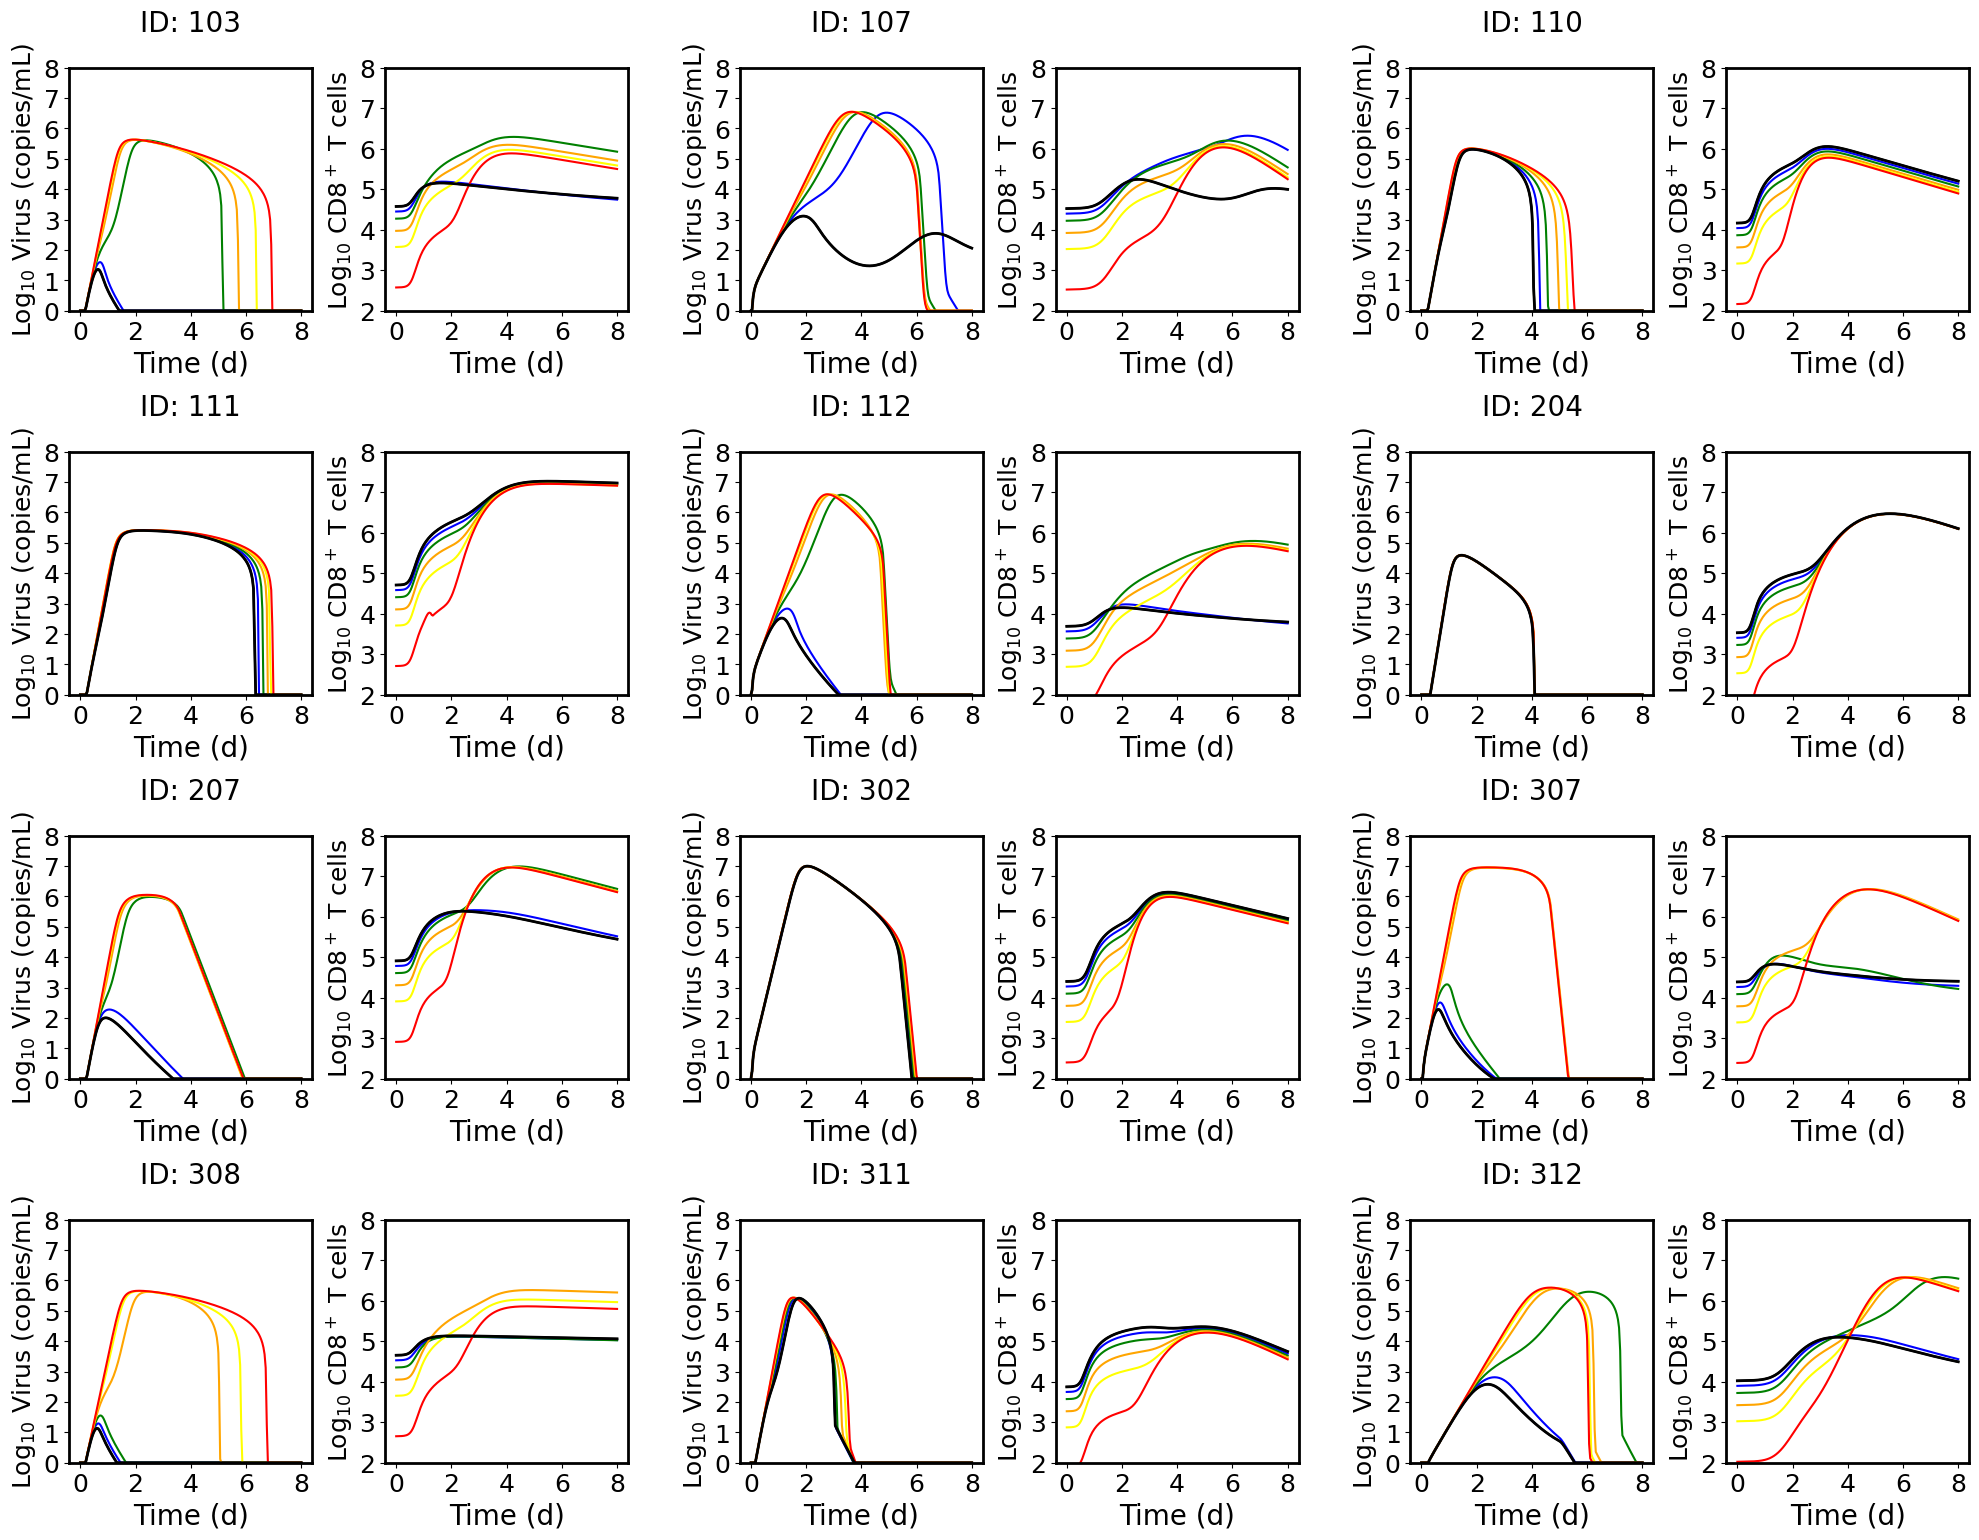

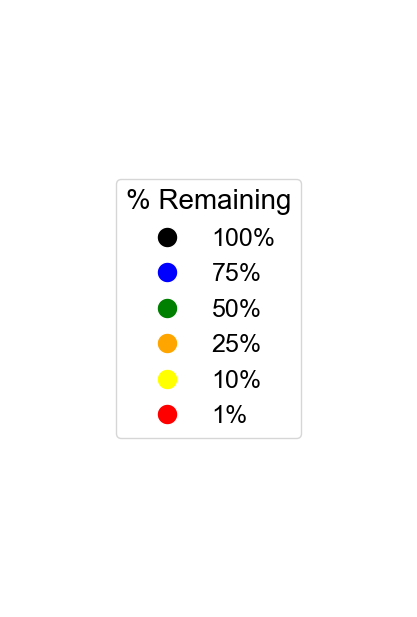

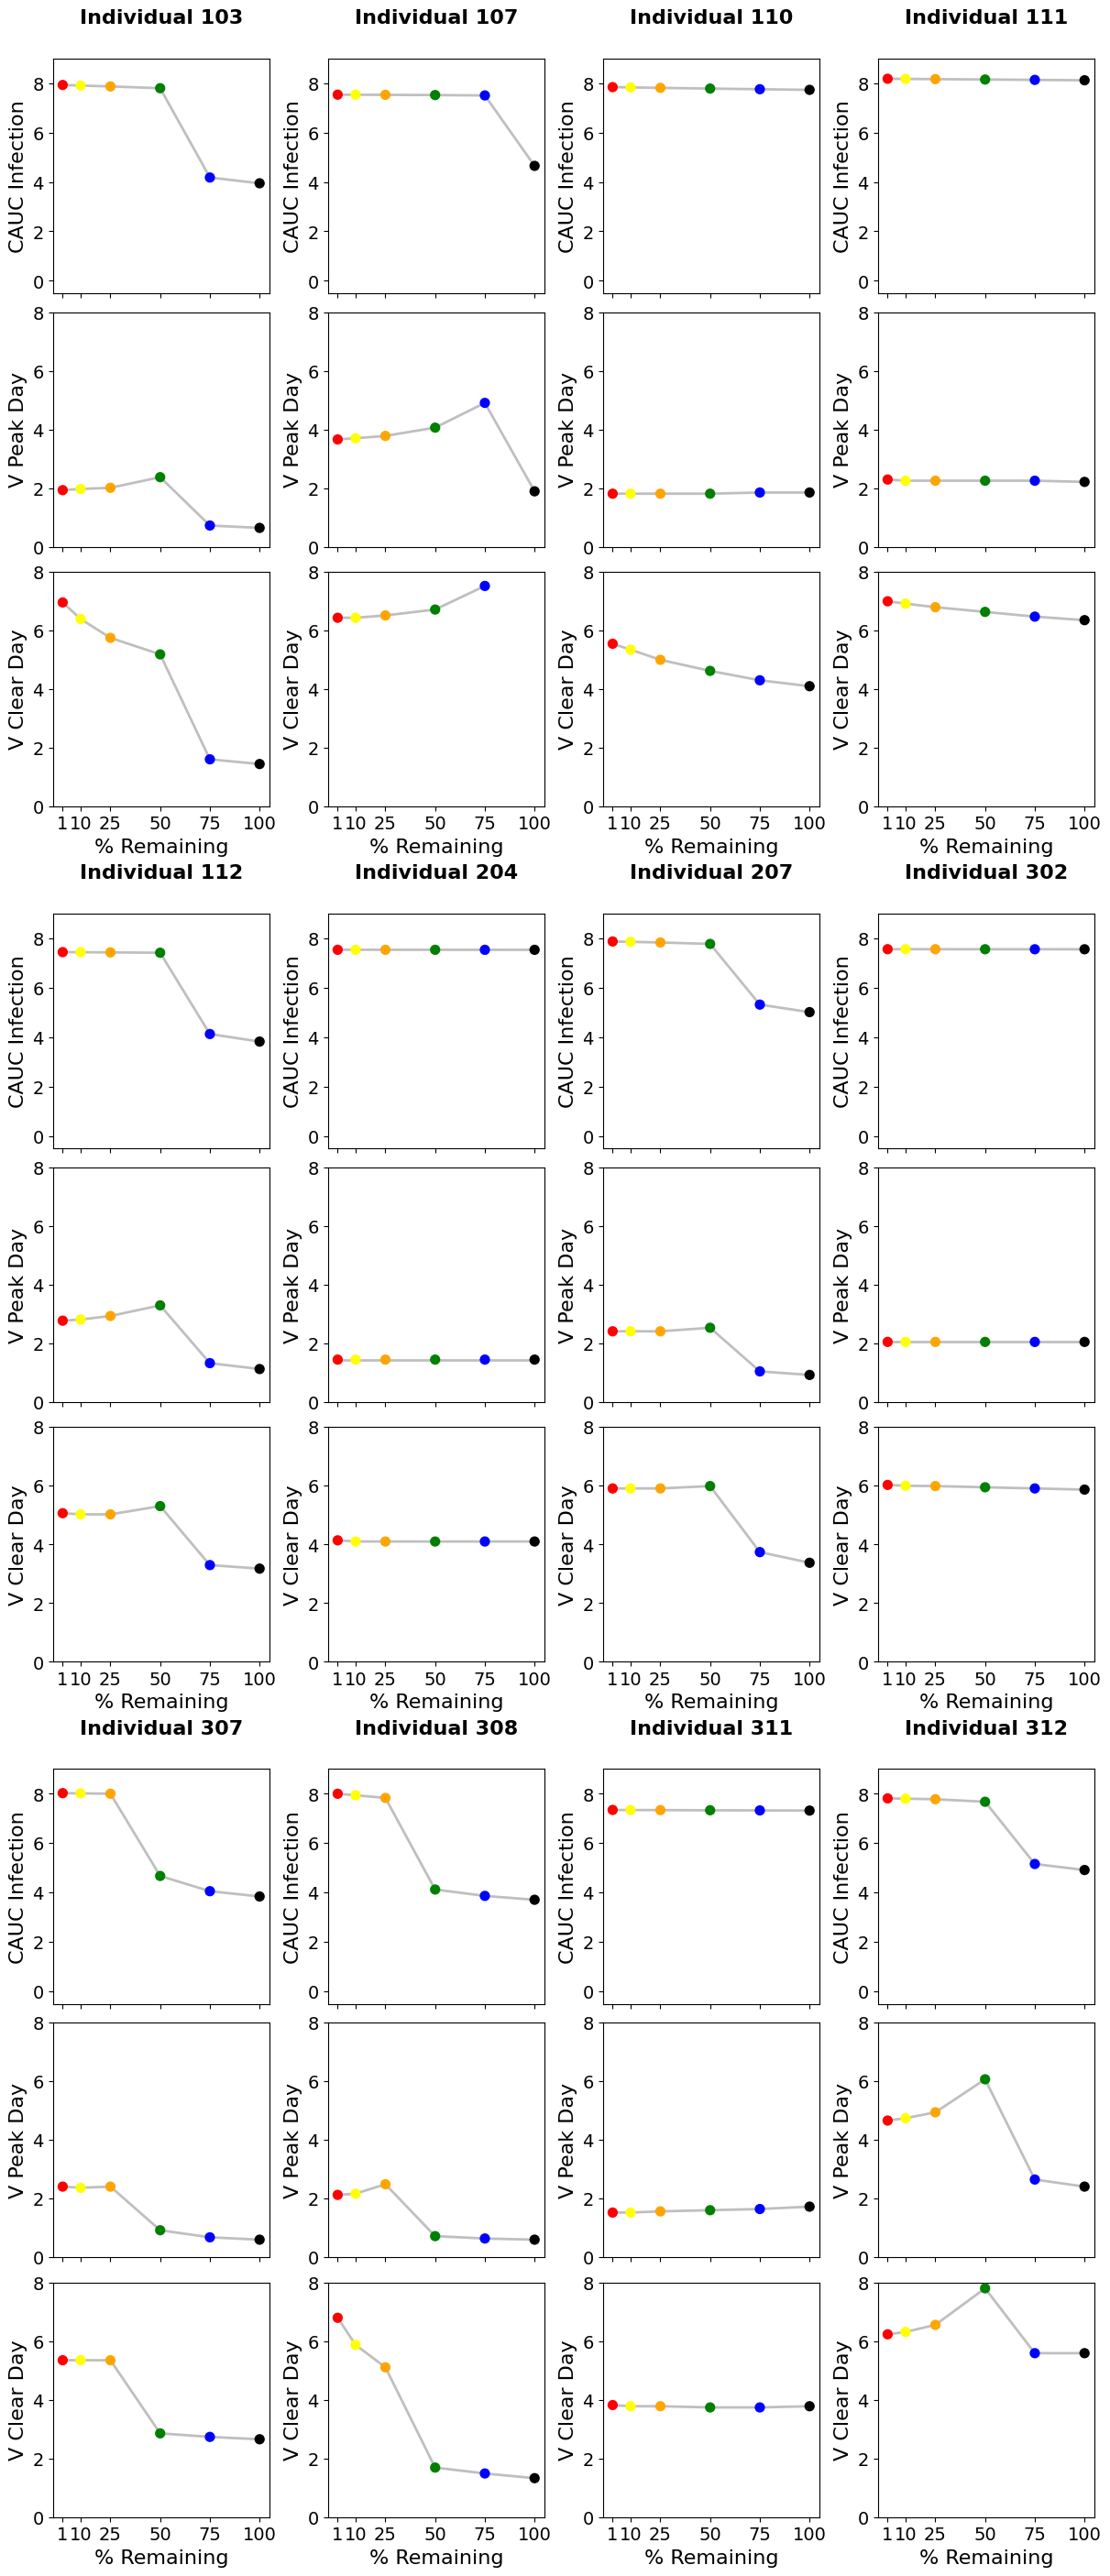

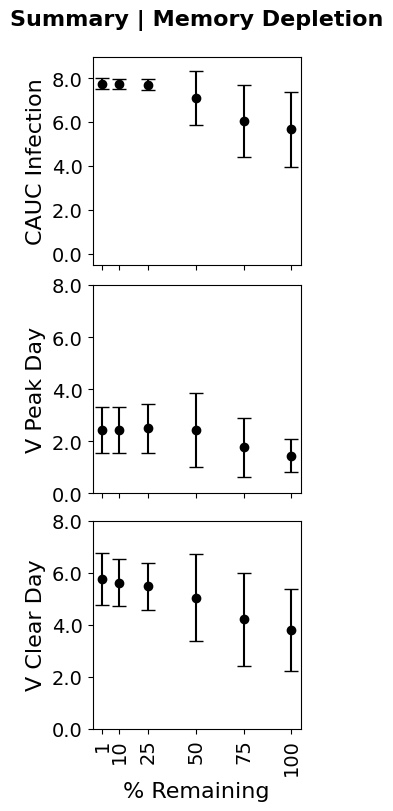

In [9]:
def run_simulation_decay(t_span, y0, base_params, decay_list):
    t_fill = np.linspace(t_span[0], t_span[-1], 200)
    t_int = np.arange(t_span[0], t_span[-1] + 1)
    t_span_full = np.unique(np.concatenate([np.array(t_span), t_fill, t_int]))
    
    param_order = ["beta", "k", "p", "c", "delta", "xi", "a", 
                   "d_E", "delta_E", "K_delta_E", "zeta", "eta", "K_I1", 
                   "tau_memory", "damp"]
    
    solutions = []
    cauc_values, cauc_infected_values, peak_days, clear_days = [], [], [], []
    
    for percent_remaining in decay_list:
        decayed_ME = base_params["ME"] * (percent_remaining / 100.0)
        y0_sim = y0.copy()
        y0_sim[0] = base_params["T0"]
        y0_sim[5] = decayed_ME
        y0_sim = [float(x) for x in y0_sim]
        
        params_py = [float(np.float64(base_params[k])) for k in param_order]
        params_julia = Main.eval("[" + ",".join(map(str, params_py)) + "]")
        
        result = Main.tmap_ReinfectionModel(t_span_full, y0_sim, params_julia)
        t_values, y_values = result[0]
        sol = {"t": np.array(t_values, dtype=np.float64),
               "y": np.array(y_values, dtype=np.float64),
               "percent_remaining": percent_remaining,
               "decayed_ME": decayed_ME}
        solutions.append(sol)
        
        # Compute CAUC Virus
        t_arr = sol["t"]
        virus = sol["y"][3, :]
        auc_virus = np.trapezoid(virus, t_arr)
        cauc_values.append(auc_virus)
        
        # Compute CAUC Infected Cells (I1 + I2)
        infected_cells = sol["y"][1, :] + sol["y"][2, :]
        auc_infected = np.trapezoid(infected_cells, t_arr)
        cauc_infected_values.append(auc_infected)
        
        # Peak day calculation
        peak_idx = np.argmax(virus)
        peak_days.append(t_arr[peak_idx])
        
        # Clearance day calculation
        clear_time = np.nan
        for j in range(peak_idx + 1, len(t_arr)):
            if virus[j] < 1:
                clear_time = t_arr[j]
                break
        clear_days.append(clear_time)
        
    y0_baseline = y0.copy()
    y0_baseline[0] = base_params["T0"]
    y0_baseline[5] = base_params["ME"]
    y0_baseline = [float(x) for x in y0_baseline]
    
    baseline_params_py = [float(np.float64(base_params[k])) for k in param_order]
    baseline_params_julia = Main.eval("[" + ",".join(map(str, baseline_params_py)) + "]")
    baseline_result = Main.tmap_ReinfectionModel(t_span_full, y0_baseline, baseline_params_julia)
    baseline_tuple = baseline_result[0]
    baseline = {"t": np.array(baseline_tuple[0], dtype=np.float64),
                "y": np.array(baseline_tuple[1], dtype=np.float64)}
                
    sim_data = {
        "percent_list": np.array(decay_list, dtype=np.float64),
        "solutions": solutions,
        "baseline": baseline,
        "cauc_values": np.array(cauc_values, dtype=np.float64),
        "cauc_infected_values": np.array(cauc_infected_values, dtype=np.float64),
        "peak_days": np.array(peak_days, dtype=np.float64),
        "clear_days": np.array(clear_days, dtype=np.float64),
        "base_ME": base_params["ME"]
    }
    return sim_data

def plot_individual_dynamics_decay(fig, cell_gs, sim_data, t_span, Zero_conditions, indiv_id):
    gs_dyn = mpl.gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=cell_gs, wspace=0.3)
    ax_virus = fig.add_subplot(gs_dyn[0])
    ax_effector = fig.add_subplot(gs_dyn[1])
    
    # Style spines as in the primary function.
    for spine in ax_virus.spines.values():
        spine.set_color('black')
        spine.set_linewidth(2)
    for spine in ax_effector.spines.values():
        spine.set_color('black')
        spine.set_linewidth(2)
    
    percent_list = sim_data["percent_list"]
    solutions = sim_data["solutions"]
    
    # Define custom color mapping
    color_map = {
        100: 'black',
        75: 'blue',
        50: 'green',
        25: 'orange',
        10: 'yellow',
        1: 'red'
    }
    
    # Plot simulation traces for each decay level.
    for sol in solutions:
        percent_val = sol["percent_remaining"]
        color = color_map.get(percent_val, 'gray')  # Default to gray if not found
        ax_virus.plot(sol["t"], np.log10(np.maximum(sol["y"][3, :], 1)),
                      color=color, linewidth=1.5)
        ax_effector.plot(sol["t"], np.log10(np.maximum(sol["y"][4, :] + sol["y"][5, 0], 1)),
                         color=color, linewidth=1.5)
    
    # Plot the baseline simulation in black.
    baseline = sim_data["baseline"]
    ax_virus.plot(baseline["t"], np.log10(np.maximum(baseline["y"][3, :], 1)),
                  color='black', linewidth=2)
    ax_effector.plot(baseline["t"], np.log10(np.maximum(baseline["y"][4, :] + Zero_conditions["ME"], 1)),
                     color='black', linewidth=2)
    
    ax_virus.set_yticks(np.arange(0, 9, 1))
    ax_effector.set_yticks(np.arange(2, 9, 1))
    ax_virus.set_xticks([0, 2, 4, 6, 8])
    ax_effector.set_xticks([0, 2, 4, 6, 8])
    ax_virus.set_ylabel('Log$_{10}$ Virus (copies/mL)', fontsize=18)
    ax_effector.set_ylabel('Log$_{10}$ CD8$^+$ T cells', fontsize=18)
    ax_virus.set_xlabel("Time (d)", fontsize=20)
    ax_effector.set_xlabel("Time (d)", fontsize=20)
    ax_virus.tick_params(labelsize=18)
    ax_effector.tick_params(labelsize=18)
    ax_virus.set_ylim(0, 8)
    ax_effector.set_ylim(2, 8)
    ax_virus.set_box_aspect(1)
    ax_effector.set_box_aspect(1)
    
    ax_virus.text(0.5, 1.15, f"ID: {indiv_id}",
                  transform=ax_virus.transAxes, fontsize=20, ha='center')

    # Save the dynamics figure as SVG
    plt.savefig(f'../plots/sensitivity/memory/dynamics_{indiv_id}_decay.svg', format='svg', bbox_inches='tight')

def plot_individual_metrics_decay(fig, cell_gs, sim_data, indiv_id):
    gs_met = mpl.gridspec.GridSpecFromSubplotSpec(3, 1, subplot_spec=cell_gs, hspace=0)
    ax_auc_inf = fig.add_subplot(gs_met[0])
    ax_peak  = fig.add_subplot(gs_met[1], sharex=ax_auc_inf)
    ax_clear = fig.add_subplot(gs_met[2], sharex=ax_auc_inf)
    
    plt.setp(ax_auc_inf.get_xticklabels(), visible=False)
    plt.setp(ax_peak.get_xticklabels(), visible=False)
    
    percents = sim_data["percent_list"]
    x_metric = percents
    auc_virus_metric = np.log10(sim_data["cauc_values"])
    auc_infected_metric = np.log10(sim_data["cauc_infected_values"])
    peak_metric = sim_data["peak_days"]
    clear_metric = sim_data["clear_days"]
    
    color_map = {
        100: 'black',
        75: 'blue',
        50: 'green',
        25: 'orange',
        10: 'yellow',
        1: 'red'
    }
    
    marker_colors = [color_map.get(val, 'gray') for val in percents]
    
    ax_auc_inf.scatter(x_metric, auc_infected_metric, color=marker_colors, zorder=5, s=50)
    ax_auc_inf.plot(x_metric, auc_infected_metric, color='gray', linewidth=2, alpha=0.5)
    
    ax_peak.scatter(x_metric, peak_metric, color=marker_colors, zorder=5, s=50)
    ax_peak.plot(x_metric, peak_metric, color='gray', linewidth=2, alpha=0.5)
    
    ax_clear.scatter(x_metric, clear_metric, color=marker_colors, zorder=5, s=50)
    ax_clear.plot(x_metric, clear_metric, color='gray', linewidth=2, alpha=0.5)
    
    ax_clear.set_xlabel("% Remaining", fontsize=16)
    
    ax_auc_inf.set_ylim(-0.5, 9)
    ax_peak.set_ylim(0, 8)
    ax_clear.set_ylim(0, 8)
    
    ax_auc_inf.set_xticks(x_metric)
    ax_auc_inf.set_xticklabels([int(val) for val in x_metric], fontsize=14)
    ax_peak.set_xticks(x_metric)
    ax_peak.set_xticklabels([int(val) for val in x_metric], fontsize=14)
    ax_clear.set_xticks(x_metric)
    ax_clear.set_xticklabels([int(val) for val in x_metric], fontsize=14)
    
    for ax in (ax_auc_inf, ax_peak, ax_clear):
        ax.tick_params(axis='y', labelsize=14)
        
    ax_auc_inf.set_ylabel("CAUC Infection", fontsize=16)
    ax_peak.set_ylabel("V Peak Day", fontsize=16)
    ax_clear.set_ylabel("V Clear Day", fontsize=16)
    
    ax_auc_inf.text(0.5, 1.15, f"Individual {indiv_id}",
                transform=ax_auc_inf.transAxes, fontsize=16, ha='center', fontweight='bold')

    # Save the metrics figure as SVG
    plt.savefig(f'../plots/sensitivity/memory/metrics_{indiv_id}_decay.svg', format='svg', bbox_inches='tight')

def create_global_colorbar_decay(fig, sim_data, save_path=None):
    ax = fig.add_subplot(111)
    color_map = {
        100: 'black',
        75: 'blue',
        50: 'green',
        25: 'orange',
        10: 'yellow',
        1: 'red'
    }

    legend_elements = []
    percents = sorted(color_map.keys(), reverse=True)
    
    for percent in percents:
        color = color_map[percent]
        legend_elements.append(
            Line2D([0], [0], marker='o', color='w', markerfacecolor=color,
                   markersize=15, label=f"{percent}%")
        )
    
    ax.set_axis_off()
    legend = ax.legend(handles=legend_elements, 
                       loc='center',  # Center the legend
                       title="% Remaining",
                       prop={'family': 'Arial', 'size': 18},
                       frameon=True)
    
    legend.get_title().set_fontfamily('Arial')
    legend.get_title().set_fontsize(20)
    fig.tight_layout(pad=0.1)
    
    if save_path:
        fig.savefig(save_path, format='svg', bbox_inches='tight')
    
    return legend

def plot_summary_metrics_decay(fig, cell_gs, sim_data_list):
    # Create a GridSpec for three rows and one column.
    gs_met = mpl.gridspec.GridSpecFromSubplotSpec(3, 1, subplot_spec=cell_gs, hspace=0)
    ax_auc_inf = fig.add_subplot(gs_met[0])
    ax_peak    = fig.add_subplot(gs_met[1], sharex=ax_auc_inf)
    ax_clear   = fig.add_subplot(gs_met[2], sharex=ax_auc_inf)
    
    # Hide x tick labels for the top two plots.
    plt.setp(ax_auc_inf.get_xticklabels(), visible=False)
    plt.setp(ax_peak.get_xticklabels(), visible=False)
    
    # Use the first individual's data for the x-axis info.
    base_data = sim_data_list[0]
    x_metric = base_data["percent_list"]
    
    # Define the three metric extraction functions.
    # For CAUC Infection, use the log10 of cauc_infected_values.
    metric_funcs = [
        lambda d: np.log10(d["cauc_infected_values"]),
        lambda d: d["peak_days"],
        lambda d: d["clear_days"]
    ]
    ylabels = ['CAUC Infection', 'V Peak Day', 'V Clear Day']
    
    # Set the y-axis bounds for each metric.
    y_bounds = [(-0.5, 9), (0, 8), (0, 8)]
    
    # Loop over each metric axis.
    for ax, metric_func, ylabel, (y_lower, y_upper) in zip([ax_auc_inf, ax_peak, ax_clear],
                                                             metric_funcs, ylabels, y_bounds):
        means = []
        stds = []
        # For each % tick (assumed consistent across individuals)
        for tick in x_metric:
            vals = []
            for sim_data in sim_data_list:
                # Find the index closest to the current tick.
                idx = np.argmin(np.abs(np.array(sim_data["percent_list"]) - tick))
                val = metric_func(sim_data)[idx]
                if np.isfinite(val):
                    vals.append(val)
            vals = np.array(vals)
            if vals.size > 0:
                means.append(np.mean(vals))
                stds.append(np.std(vals))
            else:
                means.append(np.nan)
                stds.append(np.nan)
        means = np.array(means)
        stds = np.array(stds)
        
        # Adjust error bars so that (mean ± error) stays within defined y-bounds.
        lower_err = np.minimum(means - y_lower, stds)
        upper_err = np.minimum(y_upper - means, stds)
        yerr = np.vstack([lower_err, upper_err])
        
        # Plot the mean with vertical error bars.
        ax.errorbar(x_metric, means, yerr=yerr, fmt='o', color='black',
                    ecolor='black', capsize=5, zorder=5)
        ax.set_ylabel(ylabel, fontsize=16)
        ax.set_ylim(y_lower, y_upper)
    
    # Configure the bottom axis: set x-label and ticks.
    ax_clear.set_xlabel("% Remaining", fontsize=16)
    ax_clear.set_xticks(x_metric)
    ax_clear.set_xticklabels([f"{int(val)}" for val in x_metric], fontsize=14, rotation=90)
    
    # Apply uniform tick parameters and aspect ratio.
    for ax in [ax_auc_inf, ax_peak, ax_clear]:
        ax.set_box_aspect(1)
        ax.tick_params(axis='x', labelsize=14)
        ax.tick_params(axis='y', labelsize=14)
        ax.yaxis.set_major_formatter(mpl.ticker.FormatStrFormatter('%.1f'))
    
    # Add a title to the top axis.
    ax_auc_inf.text(0.5, 1.15, "Summary | Memory Depletion", 
                    transform=ax_auc_inf.transAxes, fontsize=16, 
                    ha='center', fontweight='bold')
    
    plt.savefig(f'../plots/sensitivity/memory/summary_metrics_decay.svg', format='svg', bbox_inches='tight')
    
# Main block for decay sweep simulations.
t_span = (0.0, 8)
y0_master = [0, 75.0, 0.0, 0.0, 0.0, 0.0] + [0.0]*13
# Decay levels given as percentages (e.g. 100 means 100% of base ME)
percent_list = [100, 75, 50, 25, 10, 1]
sim_data_dict = {}
for indiv_id in ids:
    row = params[params['id'] == indiv_id].iloc[0]
    base_params = {
        "T0": row['T0'],
        "beta": row['beta'],
        "k": row['k'],
        "p": row['p'],
        "c": row['c'],
        "delta": row['delta'],
        "xi": row['xi'],
        "a": row['a'],
        "d_E": row['d_E'],
        "delta_E": row['delta_E'],
        "K_delta_E": row['K_delta_E'],
        "zeta": row['zeta'],
        "eta": row['eta'],
        "K_I1": row['K_I1'],
        "tau_memory": row['tau_memory'],
        "damp": row['damp'],
        "ME": row['ME']
    }
    Zero_conditions = {"ME": row['ME'], "M0": row['M0']}
    y0_local = y0_master.copy()
    sim_data = run_simulation_decay(t_span, y0_local, base_params, percent_list)
    sim_data_dict[indiv_id] = (sim_data, Zero_conditions)

n_indiv = len(ids)
n_cols = 3
n_rows = math.ceil(n_indiv / n_cols)

os.makedirs('../plots/sensitivity/memory', exist_ok=True)
# ----- Dynamics Figure -----
fig_dyn = plt.figure(figsize=(20, 16))
outer_gs_dyn = gridspec.GridSpec(n_rows, n_cols, figure=fig_dyn)
for i, indiv_id in enumerate(ids):
    cell_gs = outer_gs_dyn[i]
    sim_data, Zero_conditions = sim_data_dict[indiv_id]
    plot_individual_dynamics_decay(fig_dyn, cell_gs, sim_data, t_span, Zero_conditions, indiv_id)
plt.subplots_adjust(left=0.03, right=0.98, top=0.95, bottom=0.03)
plt.show()

# ----- Global Colorbar Figure -----
fig_cbar = plt.figure(figsize=(4, 6))  
rep_sim = sim_data_dict[ids[0]][0]
legend = create_global_colorbar_decay(fig_cbar, rep_sim, save_path='../plots/sensitivity/MemoryLegend.svg')
plt.show()

# ----- Plot Individual Metrics Figure -----
n_cols_met = 4
n_rows_met = math.ceil(n_indiv / n_cols_met)
fig_met = plt.figure(figsize=(12, 28), constrained_layout=True)
outer_gs_met = gridspec.GridSpec(n_rows_met, n_cols_met, figure=fig_met, wspace=0.05, hspace=0.05)

# Collect simulation data for the summary plot.
sim_data_list = []

for i, indiv_id in enumerate(ids):
    cell_gs = outer_gs_met[i]
    sim_data, _ = sim_data_dict[indiv_id]
    sim_data_list.append(sim_data)
    plot_individual_metrics_decay(fig_met, cell_gs, sim_data, indiv_id)

plt.show()


# ----- Plot Summary Metrics Figure for Memory Depletion -----
fig_summary = plt.figure(figsize=(10, 8), constrained_layout=True)
# Create a single subplot for the summary metrics.
gs_summary = gridspec.GridSpec(ncols=1, nrows=1, figure=fig_summary)
cell_gs = gs_summary[0]
plot_summary_metrics_decay(fig_summary, cell_gs, sim_data_list)
plt.show()

In [21]:
def run_simulation_decay(t_span, y0, base_params, decay_list):
    solutions = []
    cauc_values, peak_days, clear_days = [], [], []
    for percent_remaining in decay_list:
        # Compute the decayed ME value
        decayed_ME = base_params["ME"] * percent_remaining
        y0_local = y0.copy()
        y0_local[0] = float(base_params["T0"])
        y0_local[5] = decayed_ME  # ME is at index 5
        # Convert y0_local to a list of floats for Julia
        y0_local = [float(x) for x in y0_local]
        
        # Build parameter list in the expected order.
        params_py = [
            float(np.float64(base_params["beta"])),
            float(np.float64(base_params["k"])),
            float(np.float64(base_params["p"])),
            float(np.float64(base_params["c"])),
            float(np.float64(base_params["delta"])),
            float(np.float64(base_params["xi"])),
            float(np.float64(base_params["a"])),
            float(np.float64(base_params["d_E"])),
            float(np.float64(base_params["delta_E"])),
            float(np.float64(base_params["K_delta_E"])),
            float(np.float64(base_params["zeta"])),
            float(np.float64(base_params["eta"])),
            float(np.float64(base_params["K_I1"])),
            float(np.float64(base_params["tau_memory"])),
            float(np.float64(base_params["damp"]))
        ]
        # Convert parameter list to a native Julia Vector{Float64}
        params_julia = Main.eval("[" + ",".join(map(str, params_py)) + "]")
        
        # Call the Julia solver (non-batched call)
        t_values, y_values = Main.tmap_ReinfectionModel(t_span, y0_local, params_julia)
        sol = {"t": np.array(t_values, dtype=np.float64),
               "y": np.array(y_values, dtype=np.float64),
               "percent_remaining": percent_remaining,
               "decayed_ME": decayed_ME}
        solutions.append(sol)
        
        # Compute key metrics for sensitivity.
        t_arr = sol["t"]
        virus = sol["y"][3, :]
        auc = np.trapz(virus, t_arr)
        cauc_values.append(auc)
        peak_idx = np.argmax(virus)
        peak_days.append(t_arr[peak_idx])
        clear_time = np.nan
        for i in range(peak_idx+1, len(t_arr)):
            if virus[i] < 1:
                clear_time = t_arr[i]
                break
        clear_days.append(clear_time)
        
    # Baseline simulation (with T0 = 4E7 and original ME)
    y0_baseline = y0.copy()
    y0_baseline[0] = 4E7
    y0_baseline[5] = base_params["ME"]
    y0_baseline = [float(x) for x in y0_baseline]
    baseline_params_py = [
        float(np.float64(base_params["beta"])),
        float(np.float64(base_params["k"])),
        float(np.float64(base_params["p"])),
        float(np.float64(base_params["c"])),
        float(np.float64(base_params["delta"])),
        float(np.float64(base_params["xi"])),
        float(np.float64(base_params["a"])),
        float(np.float64(base_params["d_E"])),
        float(np.float64(base_params["delta_E"])),
        float(np.float64(base_params["K_delta_E"])),
        float(np.float64(base_params["zeta"])),
        float(np.float64(base_params["eta"])),
        float(np.float64(base_params["K_I1"])),
        float(np.float64(base_params["tau_memory"])),
        float(np.float64(base_params["damp"]))
    ]
    baseline_params_julia = Main.eval("[" + ",".join(map(str, baseline_params_py)) + "]")
    t_baseline, y_baseline = Main.tmap_ReinfectionModel(t_span, y0_baseline, baseline_params_julia)
    baseline = {"t": np.array(t_baseline, dtype=np.float64),
                "y": np.array(y_baseline, dtype=np.float64)}
    
    sim_data = {
        "percent_list": np.array(decay_list, dtype=np.float64),
        "solutions": solutions,
        "baseline": baseline,
        "cauc_values": np.array(cauc_values, dtype=np.float64),
        "peak_days": np.array(peak_days, dtype=np.float64),
        "clear_days": np.array(clear_days, dtype=np.float64),
        "base_ME": base_params["ME"]
    }
    return sim_data


def plot_individual_dynamics_decay(fig, cell_gs, sim_data, t_span, Zero_conditions, indiv_id):
    gs_dyn = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=cell_gs, wspace=0.3)
    ax_virus = fig.add_subplot(gs_dyn[0])
    ax_effector = fig.add_subplot(gs_dyn[1])
    
    # Style spines.
    for spine in ax_virus.spines.values():
        spine.set_color('black')
        spine.set_linewidth(2)
    for spine in ax_effector.spines.values():
        spine.set_color('black')
        spine.set_linewidth(2)
    
    percent_list = sim_data["percent_list"]
    solutions = sim_data["solutions"]
    cmap = plt.get_cmap("spring")
    norm_days = mpl.colors.Normalize(vmin=min(percent_list), vmax=max(percent_list))
    
    # Plot simulation traces for each decay level.
    for sol in solutions:
        # Use 'percent_remaining' as the x–value for color mapping.
        percent_val = sol["percent_remaining"]
        color = cmap(norm_days(percent_val))
        ax_virus.plot(sol["t"], np.log10(np.maximum(sol["y"][3, :], 1)),
                      color=color, linewidth=1.5)
        ax_effector.plot(sol["t"], np.log10(np.maximum(sol["y"][4, :] + sol["y"][5, 0], 1)),
                         color=color, linewidth=1.5)
    
    # Plot the baseline (black bold line).
    baseline = sim_data["baseline"]
    ax_virus.plot(baseline["t"], np.log10(np.maximum(baseline["y"][3, :], 1)),
                  color='black', linewidth=2)
    ax_effector.plot(baseline["t"], np.log10(np.maximum(baseline["y"][4, :] + Zero_conditions["ME"], 1)),
                     color='black', linewidth=2)
    
    # Set ticks and labels.
    ax_virus.set_yticks(np.arange(0, 9, 1))
    ax_effector.set_yticks(np.arange(2, 9, 1))
    ax_virus.set_xticks([0, 2, 4, 6, 8])
    ax_effector.set_xticks([0, 2, 4, 6, 8])
    ax_virus.set_ylabel('Log$_{10}$ Virus (copies/mL)', fontsize=18)
    ax_effector.set_ylabel('Log$_{10}$ CD8$^+$ T cells', fontsize=18)
    ax_virus.set_xlabel("Time (d)", fontsize=20)
    ax_effector.set_xlabel("Time (d)", fontsize=20)
    ax_virus.tick_params(labelsize=18)
    ax_effector.tick_params(labelsize=18)
    ax_virus.set_ylim(0, 8)
    ax_effector.set_ylim(2, 8)
    ax_virus.set_box_aspect(1)
    ax_effector.set_box_aspect(1)
    
    ax_virus.text(0.5, 1.15, f"ID: {indiv_id}",
                  transform=ax_virus.transAxes, fontsize=20, ha='center')


def plot_individual_metrics_decay(fig, cell_gs, sim_data, indiv_id):
    gs_met = gridspec.GridSpecFromSubplotSpec(3, 1, subplot_spec=cell_gs, hspace=0)
    ax_auc   = fig.add_subplot(gs_met[0])
    ax_peak  = fig.add_subplot(gs_met[1], sharex=ax_auc)
    ax_clear = fig.add_subplot(gs_met[2], sharex=ax_auc)
    
    plt.setp(ax_auc.get_xticklabels(), visible=False)
    plt.setp(ax_peak.get_xticklabels(), visible=False)
    
    percents = sim_data["percent_list"]
    x_metric = percents
    auc_metric = np.log10(sim_data["cauc_values"])
    peak_metric = sim_data["peak_days"]
    clear_metric = sim_data["clear_days"]
    
    cmap = plt.get_cmap("spring")
    norm_days = mpl.colors.Normalize(vmin=min(percents), vmax=max(percents))
    marker_colors = [cmap(norm_days(val)) for val in percents]
    
    ax_auc.scatter(x_metric, auc_metric, color=marker_colors, zorder=5, s=50)
    ax_auc.plot(x_metric, auc_metric, color='gray', linewidth=2, alpha=0.5)
    
    ax_peak.scatter(x_metric, peak_metric, color=marker_colors, zorder=5, s=50)
    ax_peak.plot(x_metric, peak_metric, color='gray', linewidth=2, alpha=0.5)
    
    ax_clear.scatter(x_metric, clear_metric, color=marker_colors, zorder=5, s=50)
    ax_clear.plot(x_metric, clear_metric, color='gray', linewidth=2, alpha=0.5)
    
    ax_clear.set_xlabel("% Remaining", fontsize=16)
    
    ax_auc.set_ylim(-0.5, 8)
    ax_peak.set_ylim(0, 8)
    ax_clear.set_ylim(0, 8)
    
    # Set x ticks only where scatter points are and label these as whole numbers.
    ax_auc.set_xticks(x_metric)
    ax_auc.set_xticklabels([int(val) for val in x_metric], fontsize=14)
    ax_peak.set_xticks(x_metric)
    ax_peak.set_xticklabels([int(val) for val in x_metric], fontsize=14)
    ax_clear.set_xticks(x_metric)
    ax_clear.set_xticklabels([int(val) for val in x_metric], fontsize=14)
    
    for ax in (ax_auc, ax_peak, ax_clear):
        ax.tick_params(axis='y', labelsize=14)
        
    ax_auc.set_ylabel("Log$_{10}$ CAUC V", fontsize=16)
    ax_peak.set_ylabel("V Peak Day", fontsize=16)
    ax_clear.set_ylabel("V Clear Day", fontsize=16)
    ax_auc.text(0.5, 1.15, f"Individual {indiv_id}",
                transform=ax_auc.transAxes, fontsize=16, ha='center', fontweight='bold')


def create_global_colorbar_decay(fig, sim_data):
    # Use the percent_list as the colorbar values.
    days = sim_data["percent_list"]
    cmap = plt.get_cmap("spring")
    norm_days = mpl.colors.Normalize(vmin=min(days), vmax=max(days))
    cbar_ax = fig.add_axes([0.25, 0.15, 0.1, 0.7])
    cbar = mpl.colorbar.ColorbarBase(cbar_ax, cmap=cmap, norm=norm_days, orientation='vertical')
    cbar.set_ticks(days)
    cbar.set_ticklabels([f"{int(day)}" for day in days])
    cbar.ax.tick_params(labelsize=20, which='both', length=6)
    cbar.ax.set_ylabel("Elapsed Time (days)", fontsize=20)


# Main block for decay sweep simulations.
t_span = (0.0, 8)
y0_master = [0, 75.0, 0.0, 0.0, 0.0, 0.0] + [0.0]*13
percent_list = [100, 75, 50, 25, 10, 1]

sim_data_dict = {}
for indiv_id in ids:
    row = params[params['id'] == indiv_id].iloc[0]
    base_params = {
        "T0": row['T0'],
        "beta": row['beta'],
        "k": row['k'],
        "p": row['p'],
        "c": row['c'],
        "delta": row['delta'],
        "xi": row['xi'],
        "a": row['a'],
        "d_E": row['d_E'],
        "delta_E": row['delta_E'],
        "K_delta_E": row['K_delta_E'],
        "zeta": row['zeta'],
        "eta": row['eta'],
        "K_I1": row['K_I1'],
        "tau_memory": row['tau_memory'],
        "damp": row['damp'],
        "ME": row['ME']
    }
    Zero_conditions = {"ME": row['ME'], "M0": row['M0']}
    y0_local = y0_master.copy()
    sim_data = run_simulation_decay(t_span, y0_local, base_params, percent_list)
    sim_data_dict[indiv_id] = (sim_data, Zero_conditions)


n_indiv = len(ids)
n_cols = 3
n_rows = math.ceil(n_indiv / n_cols)

# ----- Dynamics Figure -----
fig_dyn = plt.figure(figsize=(20, 16))
outer_gs_dyn = gridspec.GridSpec(n_rows, n_cols, figure=fig_dyn)
for i, indiv_id in enumerate(ids):
    cell_gs = outer_gs_dyn[i]
    sim_data, Zero_conditions = sim_data_dict[indiv_id]
    plot_individual_dynamics_decay(fig_dyn, cell_gs, sim_data, t_span, Zero_conditions, indiv_id)
plt.subplots_adjust(left=0.03, right=0.98, top=0.95, bottom=0.03)
plt.show()

# ----- Global Colorbar Figure -----
fig_cbar = plt.figure(figsize=(10, 10))
rep_sim = sim_data_dict[ids[0]][0]
create_global_colorbar_decay(fig_cbar, rep_sim)
plt.subplots_adjust(left=0.1, right=0.9, top=0.85, bottom=0.2)
plt.show()

# ----- Metrics Figure -----
n_cols_met = 4
n_rows_met = math.ceil(n_indiv / n_cols_met)
fig_met = plt.figure(figsize=(12, 28), constrained_layout=True)
outer_gs_met = gridspec.GridSpec(n_rows_met, n_cols_met, figure=fig_met, wspace=0.05, hspace=0.05)
for i, indiv_id in enumerate(ids):
    cell_gs = outer_gs_met[i]
    sim_data, _ = sim_data_dict[indiv_id]
    plot_individual_metrics_decay(fig_met, cell_gs, sim_data, indiv_id)
plt.show()


ValueError: not enough values to unpack (expected 2, got 1)

In [17]:
def run_simulation_decay(t_span, y0, base_params, decay_list):
    solutions = []
    cauc_values, peak_days, clear_days = [], [], []
    for percent_remaining in decay_list:
        decayed_ME = base_params["ME"] * percent_remaining
        y0_local = y0.copy()
        y0_local[0] = float(base_params["T0"])
        y0_local[5] = decayed_ME  # ME is at index 5
        params_julia = [
            float(np.float64(base_params["beta"])),
            float(np.float64(base_params["k"])),
            float(np.float64(base_params["p"])),
            float(np.float64(base_params["c"])),
            float(np.float64(base_params["delta"])),
            float(np.float64(base_params["xi"])),
            float(np.float64(base_params["a"])),
            float(np.float64(base_params["d_E"])),
            float(np.float64(base_params["delta_E"])),
            float(np.float64(base_params["K_delta_E"])),
            float(np.float64(base_params["zeta"])),
            float(np.float64(base_params["eta"])),
            float(np.float64(base_params["K_I1"])),
            float(np.float64(base_params["tau_memory"])),
            float(np.float64(base_params["damp"]))
        ]
        t_values, y_values = Main.tmap_ReinfectionModel(t_span, y0_local, params_julia)
        sol = {"t": np.array(t_values, dtype=np.float64),
               "y": np.array(y_values, dtype=np.float64),
               "percent_remaining": percent_remaining,
               "decayed_ME": decayed_ME}
        solutions.append(sol)
        
        # Compute metrics for sensitivity.
        t_arr = sol["t"]
        virus = sol["y"][3, :]
        auc = np.trapezoid(virus, t_arr)
        cauc_values.append(auc)
        peak_idx = np.argmax(virus)
        peak_days.append(t_arr[peak_idx])
        clear_time = np.nan
        for i in range(peak_idx+1, len(t_arr)):
            if virus[i] < 1:
                clear_time = t_arr[i]
                break
        clear_days.append(clear_time)
        
    # Baseline simulation (with T0 = 4E7 and original ME)
    y0_baseline = y0.copy()
    y0_baseline[0] = 4E7
    y0_baseline[5] = base_params["ME"]
    baseline_params_list = [
            float(np.float64(base_params["beta"])),
            float(np.float64(base_params["k"])),
            float(np.float64(base_params["p"])),
            float(np.float64(base_params["c"])),
            float(np.float64(base_params["delta"])),
            float(np.float64(base_params["xi"])),
            float(np.float64(base_params["a"])),
            float(np.float64(base_params["d_E"])),
            float(np.float64(base_params["delta_E"])),
            float(np.float64(base_params["K_delta_E"])),
            float(np.float64(base_params["zeta"])),
            float(np.float64(base_params["eta"])),
            float(np.float64(base_params["K_I1"])),
            float(np.float64(base_params["tau_memory"])),
            float(np.float64(base_params["damp"]))
        ]
    t_baseline, y_baseline = Main.tmap_ReinfectionModel(t_span, y0_baseline, baseline_params_list)
    baseline = {"t": np.array(t_baseline, dtype=np.float64),
                "y": np.array(y_baseline, dtype=np.float64)}
    
    sim_data = {
        "percent_list": np.array(decay_list, dtype=np.float64),
        "solutions": solutions,
        "baseline": baseline,
        "cauc_values": np.array(cauc_values, dtype=np.float64),
        "peak_days": np.array(peak_days, dtype=np.float64),
        "clear_days": np.array(clear_days, dtype=np.float64),
        "base_ME": base_params["ME"]
    }
    return sim_data

def plot_individual_dynamics_decay(fig, cell_gs, sim_data, t_span, Zero_conditions, indiv_id):
    gs_dyn = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=cell_gs, wspace=0.3)
    ax_virus = fig.add_subplot(gs_dyn[0])
    ax_effector = fig.add_subplot(gs_dyn[1])
    
    # Style spines.
    for spine in ax_virus.spines.values():
        spine.set_color('black')
        spine.set_linewidth(2)
    for spine in ax_effector.spines.values():
        spine.set_color('black')
        spine.set_linewidth(2)
    
    percent_list = sim_data["percent_list"]
    solutions = sim_data["solutions"]
    cmap = plt.get_cmap("spring")
    norm_days = mpl.colors.Normalize(vmin=min(percent_list), vmax=max(percent_list))
    
    # Plot simulation traces for each elapsed day.
    for sol in solutions:
        day = sol["day"]
        color = cmap(norm_days(day))
        ax_virus.plot(sol["t"], np.log10(np.maximum(sol["y"][3, :], 1)),
                      color=color, linewidth=1.5)
        ax_effector.plot(sol["t"], np.log10(np.maximum(sol["y"][4, :] + sol["y"][5, 0], 1)),
                         color=color, linewidth=1.5)
    
    # Plot the baseline (black bold line).
    baseline = sim_data["baseline"]
    ax_virus.plot(baseline["t"], np.log10(np.maximum(baseline["y"][3, :], 1)),
                  color='black', linewidth=2)
    ax_effector.plot(baseline["t"], np.log10(np.maximum(baseline["y"][4, :] + Zero_conditions["ME"], 1)),
                     color='black', linewidth=2)
    
    # Set ticks and labels.
    ax_virus.set_yticks(np.arange(0, 9, 1))
    ax_effector.set_yticks(np.arange(2, 9, 1))
    ax_virus.set_xticks([0, 2, 4, 6, 8])
    ax_effector.set_xticks([0, 2, 4, 6, 8])
    ax_virus.set_ylabel('Log$_{10}$ Virus (copies/mL)', fontsize=18)
    ax_effector.set_ylabel('Log$_{10}$ CD8$^+$T cells', fontsize=18)
    ax_virus.set_xlabel("Time (d)", fontsize=20)
    ax_effector.set_xlabel("Time (d)", fontsize=20)
    ax_virus.tick_params(labelsize=18)
    ax_effector.tick_params(labelsize=18)
    ax_virus.set_ylim(0, 8)
    ax_effector.set_ylim(2, 8)
    ax_virus.set_box_aspect(1)
    ax_effector.set_box_aspect(1)
    
    ax_virus.text(0.5, 1.15, f"ID: {indiv_id}",
                  transform=ax_virus.transAxes, fontsize=20, ha='center')

def plot_individual_metrics_decay(fig, cell_gs, sim_data, indiv_id):
    gs_met = gridspec.GridSpecFromSubplotSpec(3, 1, subplot_spec=cell_gs, hspace=0)
    ax_auc   = fig.add_subplot(gs_met[0])
    ax_peak  = fig.add_subplot(gs_met[1], sharex=ax_auc)
    ax_clear = fig.add_subplot(gs_met[2], sharex=ax_auc)
    
    plt.setp(ax_auc.get_xticklabels(), visible=False)
    plt.setp(ax_peak.get_xticklabels(), visible=False)
    
    percents = sim_data["percent_list"]
    x_metric = percents
    auc_metric = np.log10(sim_data["cauc_values"])
    peak_metric = sim_data["peak_days"]
    clear_metric = sim_data["clear_days"]
    
    cmap = plt.get_cmap("spring")
    norm_days = mpl.colors.Normalize(vmin=min(percents), vmax=max(percents))
    marker_colors = [cmap(norm_days(day)) for day in percents]
    
    ax_auc.scatter(x_metric, auc_metric, color=marker_colors, zorder=5, s=50)
    ax_auc.plot(x_metric, auc_metric, color='gray', linewidth=2, alpha=0.5)
    
    ax_peak.scatter(x_metric, peak_metric, color=marker_colors, zorder=5, s=50)
    ax_peak.plot(x_metric, peak_metric, color='gray', linewidth=2, alpha=0.5)
    
    ax_clear.scatter(x_metric, clear_metric, color=marker_colors, zorder=5, s=50)
    ax_clear.plot(x_metric, clear_metric, color='gray', linewidth=2, alpha=0.5)
    
    ax_clear.set_xlabel("% Remaining", fontsize=16)
    
    ax_auc.set_ylim(-0.5, 8)
    ax_peak.set_ylim(0, 8)
    ax_clear.set_ylim(0, 8)
    
    # Set x ticks only where scatter points are and label these values as whole numbers
    ax_auc.set_xticks(x_metric)
    ax_auc.set_xticklabels([int(day) for day in x_metric], fontsize=14)
    ax_peak.set_xticks(x_metric)
    ax_peak.set_xticklabels([int(day) for day in x_metric], fontsize=14)
    ax_clear.set_xticks(x_metric)
    ax_clear.set_xticklabels([int(day) for day in x_metric], fontsize=14)

    for ax in (ax_auc, ax_peak, ax_clear):
        ax.tick_params(axis='y', labelsize=14)
        
    ax_auc.set_ylabel("Log$_{10}$ CAUC V", fontsize=16)
    ax_peak.set_ylabel("V Peak Day", fontsize=16)
    ax_clear.set_ylabel("V Clear Day", fontsize=16)
    ax_auc.text(0.5, 1.15, f"Individual {indiv_id}",
                transform=ax_auc.transAxes, fontsize=16, ha='center', fontweight='bold')

def create_global_colorbar_decay(fig, sim_data):
    days = sim_data["day_list"]
    cmap = plt.get_cmap("spring")
    norm_days = mpl.colors.Normalize(vmin=min(days), vmax=max(days))
    cbar_ax = fig.add_axes([0.25, 0.15, 0.1, 0.7])
    cbar = mpl.colorbar.ColorbarBase(cbar_ax, cmap=cmap, norm=norm_days, orientation='vertical')
    cbar.set_ticks(days)
    cbar.set_ticklabels([f"{day}" for day in days])
    cbar.ax.tick_params(labelsize=20, which='both', length=6)
    cbar.ax.set_ylabel("Elapsed Time (days)", fontsize=20)


t_span = (0.0, 8)
y0_master = [0, 75.0, 0.0, 0.0, 0.0, 0.0] + [0.0]*13
percent_list = [100, 75, 50, 25, 10, 1]

sim_data_dict = {}
for indiv_id in ids:
    row = params[params['id'] == indiv_id].iloc[0]
    base_params = {
        "T0": row['T0'],
        "beta": row['beta'],
        "k": row['k'],
        "p": row['p'],
        "c": row['c'],
        "delta": row['delta'],
        "xi": row['xi'],
        "a": row['a'],
        "d_E": row['d_E'],
        "delta_E": row['delta_E'],
        "K_delta_E": row['K_delta_E'],
        "zeta": row['zeta'],
        "eta": row['eta'],
        "K_I1": row['K_I1'],
        "tau_memory": row['tau_memory'],
        "damp": row['damp'],
        "ME": row['ME']
    }
    Zero_conditions = {"ME": row['ME'], "M0": row['M0']}
    y0_local = y0_master.copy()
    sim_data = run_simulation_decay(t_span, y0_local, base_params, percent_list)
    sim_data_dict[indiv_id] = (sim_data, Zero_conditions)


n_indiv = len(ids)
n_cols = 3
n_rows = math.ceil(n_indiv / n_cols)
fig_dyn = plt.figure(figsize=(20, 16))
outer_gs_dyn = gridspec.GridSpec(n_rows, n_cols, figure=fig_dyn)
for i, indiv_id in enumerate(ids):
    cell_gs = outer_gs_dyn[i]
    sim_data, Zero_conditions = sim_data_dict[indiv_id]
    plot_individual_dynamics_decay(fig_dyn, cell_gs, sim_data, t_span, Zero_conditions, indiv_id)
plt.subplots_adjust(left=0.03, right=0.98, top=0.95, bottom=0.03)
plt.show()


fig_cbar = plt.figure(figsize=(10, 10))
rep_sim = sim_data_dict[ids[0]][0]
create_global_colorbar_decay(fig_cbar, rep_sim)
plt.subplots_adjust(left=0.1, right=0.9, top=0.85, bottom=0.2)
plt.show()

n_cols_met = 4
n_rows_met = math.ceil(n_indiv / n_cols_met)
fig_met = plt.figure(figsize=(12, 28), constrained_layout=True)
outer_gs_met = gridspec.GridSpec(n_rows_met, n_cols_met, figure=fig_met, wspace=0.05, hspace=0.05)
for i, indiv_id in enumerate(ids):
    cell_gs = outer_gs_met[i]
    sim_data, _ = sim_data_dict[indiv_id]
    plot_individual_metrics_decay(fig_met, cell_gs, sim_data, indiv_id)
plt.show()

ValueError: not enough values to unpack (expected 2, got 1)

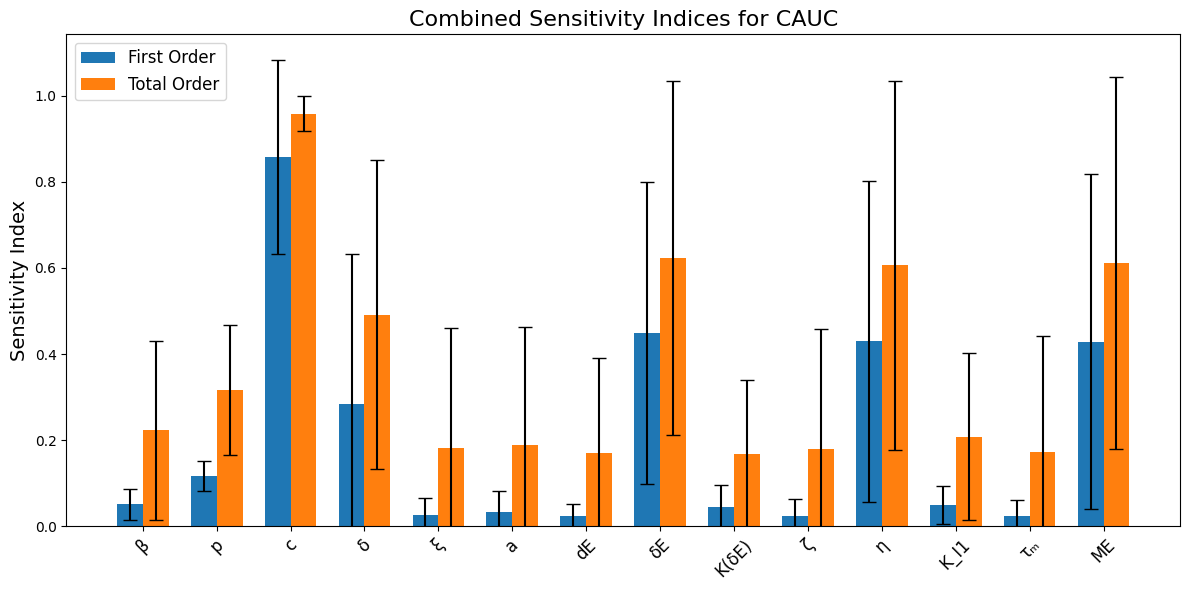

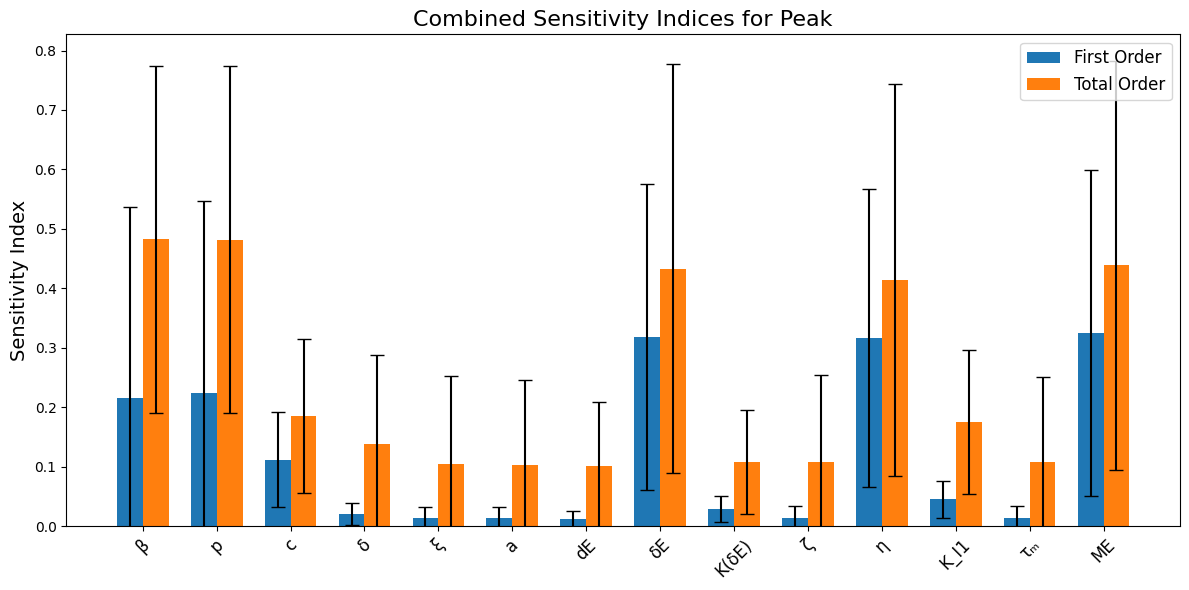

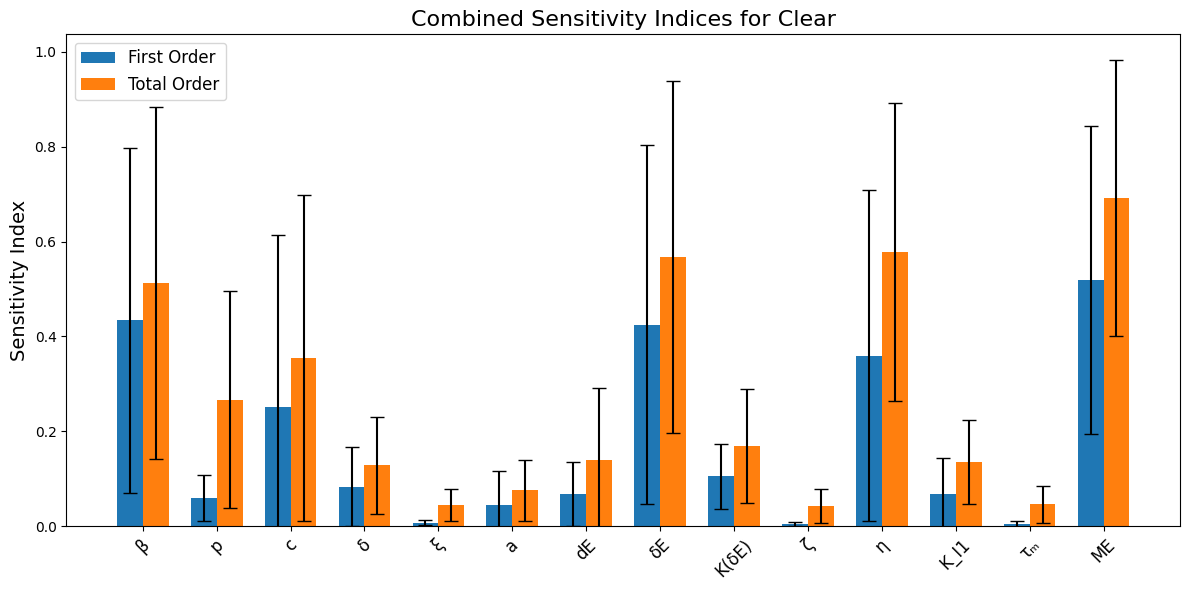

In [2]:
import os
os.environ["JULIA_NUM_THREADS"] = "1"
import sys
from julia.api import Julia
julia = Julia(sysimage="sysimage_env/sysimage.so")
from julia import Main

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.colors as mcolors
import matplotlib.gridspec as gridspec
import re, math

# Import SALib for FAST sampling and analysis
from SALib.sample import fast_sampler
from SALib.analyze import fast as fast_analyze

# -----------------------------------------------------------------------------
# Include the Julia model.
# -----------------------------------------------------------------------------
Main.include("models/Reinfection_model.jl")

# -----------------------------------------------------------------------------
# Helper: Format parameter names for pretty printing.
# -----------------------------------------------------------------------------
def format_fit_params(fit_parameter):
    if isinstance(fit_parameter, list) and len(fit_parameter) > 1:
        fit_params_str = " ".join(fit_parameter)
    else:
        fit_params_str = fit_parameter[0] if isinstance(fit_parameter, list) else fit_parameter
    replacements = {
        r"\bd_E\b": "dE",
        r"\bdelta\b": "δ",
        r"\bdelta_E\b": "δE",
        r"\bK_delta_E\b": "K(δE)",
        r"\btau\b": "τ",
        r"\bxi\b": "ξ",
        r"\bbeta\b": "β",
        r"\bdelta_E/K_delta_E\b": "Log10 [δE/KδE]",
        r"\bdelta/delta_E\b": "δ/δE",
        r"\beta\b": "η",
        r"\bzeta\b": "ζ",
        r"\btau_memory\b": "τₘ",
    }
    for pattern, replacement in replacements.items():
        fit_params_str = re.sub(pattern, replacement, fit_params_str)
    return fit_params_str

# -----------------------------------------------------------------------------
# Define the parameters to be swept.
# -----------------------------------------------------------------------------
params_to_sweep = ["beta", "p", "c", "delta", "xi", "a", "d_E", "delta_E",
                   "K_delta_E", "zeta", "eta", "K_I1", "tau_memory", "ME"]

# -----------------------------------------------------------------------------
# Model wrapper for SALib.
#
# Given a sample vector (one row from SALib’s sample matrix), update the base
# parameter set accordingly, run the simulation via Julia, and compute:
#    • CAUC (area under virus curve)
#    • Peak Day (day of maximum virus)
#    • Clear Day (first day post–peak when virus < 1)
# -----------------------------------------------------------------------------
def model_wrapper(sample, base_params, y0, t_span):
    local_params = base_params.copy()
    for i, param in enumerate(params_to_sweep):
        local_params[param] = sample[i]
    y0_local = y0.copy()
    y0_local[0] = float(base_params["T0"])
    # Use the (updated) ME value.
    y0_local[5] = local_params["ME"]
    params_julia = [
        float(np.float64(local_params["beta"])),
        float(np.float64(local_params["k"])),
        float(np.float64(local_params["p"])),
        float(np.float64(local_params["c"])),
        float(np.float64(local_params["delta"])),
        float(np.float64(local_params["xi"])),
        float(np.float64(local_params["a"])),
        float(np.float64(local_params["d_E"])),
        float(np.float64(local_params["delta_E"])),
        float(np.float64(local_params["K_delta_E"])),
        float(np.float64(local_params["zeta"])),
        float(np.float64(local_params["eta"])),
        float(np.float64(local_params["K_I1"])),
        float(np.float64(local_params["tau_memory"])),
        float(np.float64(local_params["damp"]))
    ]
    t_values, y_values = Main.tmap_ReinfectionModel(t_span, y0_local, params_julia)
    t_arr = np.array(t_values, dtype=np.float64)
    y_arr = np.array(y_values, dtype=np.float64)
    virus = y_arr[3, :]
    auc = np.trapezoid(virus, t_arr)
    peak_idx = np.argmax(virus)
    peak_day = t_arr[peak_idx]
    clear_day = np.nan
    for j in range(peak_idx+1, len(t_arr)):
        if virus[j] < 1:
            clear_day = t_arr[j]
            break
    return np.array([auc, peak_day, clear_day])

# -----------------------------------------------------------------------------
# Simulation settings.
# -----------------------------------------------------------------------------
t_span = (0.0, 8)
y0_master = [0, 75.0, 0.0, 0.0, 0.0, 0.0] + [0.0]*13
sweep_percent = 50  # ±50% variation for each parameter

# -----------------------------------------------------------------------------
# Load individual parameter sets.
# -----------------------------------------------------------------------------
params_df = pd.read_excel("Rechallenge.xlsx")
ids = params_df[params_df['id'] != 'Population']['id'].unique()

# Create unique colors for each individual.
patient_color_names = ['gray', 'purple', 'magenta', 'red', 'goldenrod', 'darkorange',
                       'saddlebrown', 'mediumblue', 'dodgerblue', 'turquoise', 'darkgreen', 'lawngreen']
patient_colors = {}
for i, pid in enumerate(ids):
    color_name = patient_color_names[i % len(patient_color_names)]
    patient_colors[pid] = mcolors.to_rgba(color_name)

# -----------------------------------------------------------------------------
# Run FAST sensitivity for each individual.
#
# For each individual we:
#   • Define a SALib “problem” where each parameter’s bounds are ±50% of its base.
#   • Use FAST sampling to generate parameter sets.
#   • Evaluate the model (returning [CAUC, Peak, Clear]) at each sample.
#   • Analyze the outputs (for each metric) to obtain S1 (first order) and ST (total order)
# -----------------------------------------------------------------------------
# We'll store results per individual in:
#   indiv_results[id][metric] = {"S1": array, "ST": array} for metric in [CAUC, Peak, Clear]
indiv_results = {}

# FAST settings
N = 65  # sample size (adjust as needed)

for indiv_id in ids:
    row = params_df[params_df['id'] == indiv_id].iloc[0]
    base_params = {
        "T0": row['T0'],
        "beta": row['beta'],
        "k": row['k'],
        "p": row['p'],
        "c": row['c'],
        "delta": row['delta'],
        "xi": row['xi'],
        "a": row['a'],
        "d_E": row['d_E'],
        "delta_E": row['delta_E'],
        "K_delta_E": row['K_delta_E'],
        "zeta": row['zeta'],
        "eta": row['eta'],
        "K_I1": row['K_I1'],
        "tau_memory": row['tau_memory'],
        "damp": row['damp'],
        "ME": row['ME']
    }
    # Define parameter bounds for each parameter (±50%).
    bounds = []
    for param in params_to_sweep:
        base_val = base_params[param]
        lower = base_val * (1 - sweep_percent/100)
        upper = base_val * (1 + sweep_percent/100)
        bounds.append([lower, upper])
    problem = {
        'num_vars': len(params_to_sweep),
        'names': params_to_sweep,
        'bounds': bounds
    }
    # Generate samples using FAST.
    param_values = fast_sampler.sample(problem, N)
    # Evaluate the model for each sample.
    Y = []  # each row: [CAUC, Peak, Clear]
    for sample in param_values:
        try:
            result = model_wrapper(sample, base_params, y0_master.copy(), t_span)
        except Exception as e:
            result = np.array([np.nan, np.nan, np.nan])
        Y.append(result)
    Y = np.array(Y)
    # For each metric, run FAST sensitivity analysis.
    indiv_results[indiv_id] = {}
    metric_names = ["CAUC", "Peak", "Clear"]
    for i, metric in enumerate(metric_names):
        Y_metric = Y[:, i]
        Si = fast_analyze.analyze(problem, Y_metric, print_to_console=False)
        # Si['S1'] and Si['ST'] are arrays for our 14 parameters.
        indiv_results[indiv_id][metric] = {"S1": Si["S1"], "ST": Si["ST"]}

# -----------------------------------------------------------------------------
# Aggregate sensitivity indices across individuals.
#
# For each metric and each parameter, we collect the indices (from each individual)
# and then compute the mean and standard deviation.
# -----------------------------------------------------------------------------
aggregated = {metric: {param: {"S1": [], "ST": []} for param in params_to_sweep} 
              for metric in ["CAUC", "Peak", "Clear"]}

for indiv_id in ids:
    for metric in ["CAUC", "Peak", "Clear"]:
        S1_array = indiv_results[indiv_id][metric]["S1"]
        ST_array = indiv_results[indiv_id][metric]["ST"]
        for i, param in enumerate(params_to_sweep):
            aggregated[metric][param]["S1"].append(S1_array[i])
            aggregated[metric][param]["ST"].append(ST_array[i])

agg_means = {metric: {"S1": [], "ST": []} for metric in ["CAUC", "Peak", "Clear"]}
agg_stds = {metric: {"S1": [], "ST": []} for metric in ["CAUC", "Peak", "Clear"]}
for metric in ["CAUC", "Peak", "Clear"]:
    for param in params_to_sweep:
        s1_vals = np.array(aggregated[metric][param]["S1"])
        st_vals = np.array(aggregated[metric][param]["ST"])
        agg_means[metric]["S1"].append(np.nanmean(s1_vals))
        agg_means[metric]["ST"].append(np.nanmean(st_vals))
        agg_stds[metric]["S1"].append(np.nanstd(s1_vals))
        agg_stds[metric]["ST"].append(np.nanstd(st_vals))

# -----------------------------------------------------------------------------
# Plotting:
# For each metric, produce three figures:
# 1. Combined bar plot (first order and total order together) with y-axis ≥ 0.
# 2. Scatter plot for first-order indices (each individual's point in its unique color).
# 3. Scatter plot for total-order indices (each individual's point in its unique color).
# -----------------------------------------------------------------------------
x = np.arange(len(params_to_sweep))
width = 0.35
metric_names = ["CAUC", "Peak", "Clear"]

for metric in metric_names:
    # Combined bar plot.
    fig, ax = plt.subplots(figsize=(12, 6))
    first_means = agg_means[metric]["S1"]
    first_std   = agg_stds[metric]["S1"]
    total_means = agg_means[metric]["ST"]
    total_std   = agg_stds[metric]["ST"]
    
    ax.bar(x - width/2, first_means, width, yerr=first_std, capsize=5, label="First Order")
    ax.bar(x + width/2, total_means, width, yerr=total_std, capsize=5, label="Total Order")
    ax.set_xticks(x)
    ax.set_xticklabels([format_fit_params([param]) for param in params_to_sweep], rotation=45, fontsize=12)
    ax.set_ylabel("Sensitivity Index", fontsize=14)
    ax.set_title(f"Combined Sensitivity Indices for {metric}", fontsize=16)
    ax.legend(fontsize=12)
    ax.set_ylim(bottom=0)
    plt.tight_layout()
    plt.show()

# Save First Order and Total Order results to CSV
first_order_df = pd.DataFrame({param: [indiv_results[indiv_id]["CAUC"]["S1"][i] for indiv_id in ids] for i, param in enumerate(params_to_sweep)}, index=ids)
first_order_df.to_csv("first_order_sensitivity_reinfection.csv")

total_order_df = pd.DataFrame({param: [indiv_results[indiv_id]["CAUC"]["ST"][i] for indiv_id in ids] for i, param in enumerate(params_to_sweep)}, index=ids)
total_order_df.to_csv("total_order_sensitivity_reinfection.csv")



103 [[np.float64(3.72913395074297e-05), np.float64(0.00011187401852228911)], [np.float64(1.262210263369175), np.float64(3.786630790107525)], [np.float64(88.544429324759), np.float64(265.633287974277)], [np.float64(0.2051179760006325), np.float64(0.6153539280018975)], [np.float64(0.050964228006234), np.float64(0.15289268401870199)], [np.float64(3.61736035873066), np.float64(10.852081076191979)], [np.float64(0.129684812772384), np.float64(0.38905443831715203)], [np.float64(1.922405279451425), np.float64(5.767215838354275)], [np.float64(1226.32373084198), np.float64(3678.97119252594)], [np.float64(0.01119455867050685), np.float64(0.03358367601152055)], [np.float64(0.1306903277527825), np.float64(0.3920709832583475)]]
107 [[np.float64(8.148466179703e-07), np.float64(2.4445398539108998e-06)], [np.float64(3.51828816188927), np.float64(10.55486448566781)], [np.float64(16.4071205513041), np.float64(49.2213616539123)], [np.float64(0.79320603425139), np.float64(2.3796181027541703)], [np.float64(

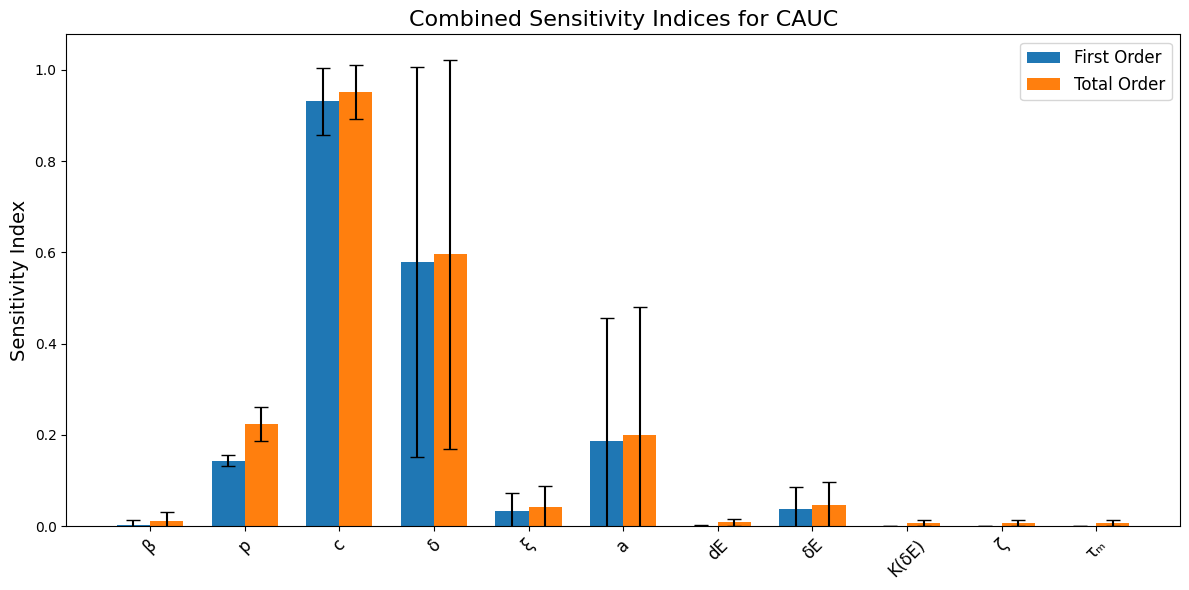

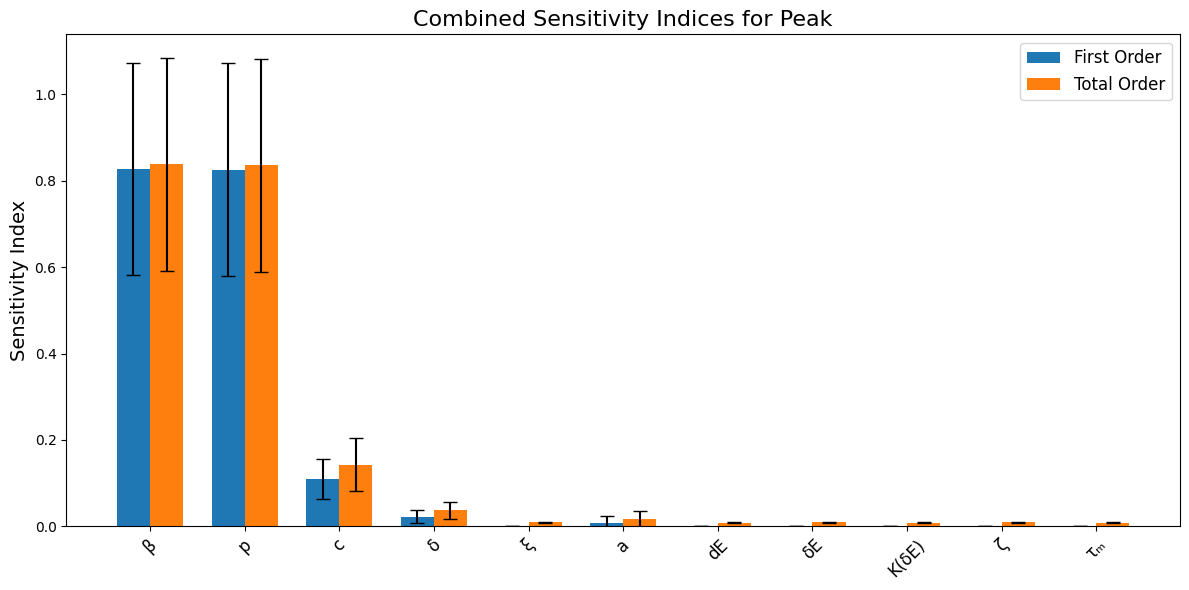

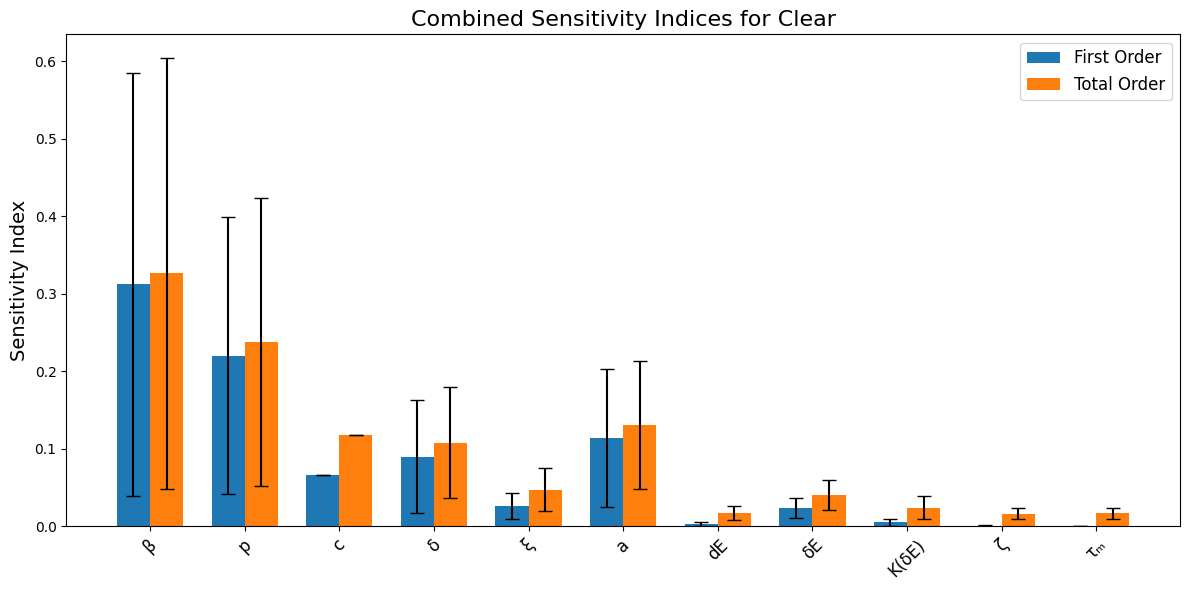

In [9]:

Main.include("models/memory_model.jl")

# -----------------------------------------------------------------------------
# Helper: Format parameter names for pretty printing.
# -----------------------------------------------------------------------------
def format_fit_params(fit_parameter):
    if isinstance(fit_parameter, list) and len(fit_parameter) > 1:
        fit_params_str = " ".join(fit_parameter)
    else:
        fit_params_str = fit_parameter[0] if isinstance(fit_parameter, list) else fit_parameter
    replacements = {
        r"\bd_E\b": "dE",
        r"\bdelta\b": "δ",
        r"\bdelta_E\b": "δE",
        r"\bK_delta_E\b": "K(δE)",
        r"\btau\b": "τ",
        r"\bxi\b": "ξ",
        r"\bbeta\b": "β",
        r"\bdelta_E/K_delta_E\b": "Log10 [δE/KδE]",
        r"\bdelta/delta_E\b": "δ/δE",
        r"\beta\b": "η",
        r"\bzeta\b": "ζ",
        r"\btau_memory\b": "τₘ",
    }
    for pattern, replacement in replacements.items():
        fit_params_str = re.sub(pattern, replacement, fit_params_str)
    return fit_params_str

# -----------------------------------------------------------------------------
# Define the parameters to be swept.
# -----------------------------------------------------------------------------
params_to_sweep = ["beta", "p", "c", "delta", "xi", "a", "d_E", "delta_E",
                   "K_delta_E", "zeta", "tau_memory"]

# -----------------------------------------------------------------------------
# Model wrapper for SALib.
#
# Given a sample vector (one row from SALib’s sample matrix), update the base
# parameter set accordingly, run the simulation via Julia, and compute:
#    • CAUC (area under virus curve)
#    • Peak Day (day of maximum virus)
#    • Clear Day (first day post–peak when virus < 1)
# -----------------------------------------------------------------------------
def model_wrapper(sample, base_params, y0, t_span):
    local_params = base_params.copy()
    for i, param in enumerate(params_to_sweep):
        local_params[param] = sample[i]
    y0_local = y0.copy()
    y0_local[0] = float(base_params["T0"])

    params_julia = [
        float(np.float64(local_params["beta"])),
        float(np.float64(local_params["k"])),
        float(np.float64(local_params["p"])),
        float(np.float64(local_params["c"])),
        float(np.float64(local_params["delta"])),
        float(np.float64(local_params["xi"])),
        float(np.float64(local_params["a"])),
        float(np.float64(local_params["d_E"])),
        float(np.float64(local_params["delta_E"])),
        float(np.float64(local_params["K_delta_E"])),
        float(np.float64(local_params["zeta"])),
        float(np.float64(local_params["eta"])),
        float(np.float64(local_params["K_I1"])),
        float(np.float64(local_params["tau_memory"])),
    ]
    t_values, y_values = Main.tmap_LCTModel(t_span, y0_local, params_julia)
    t_arr = np.array(t_values, dtype=np.float64)
    y_arr = np.array(y_values, dtype=np.float64)
    virus = y_arr[3, :]
    auc = np.trapezoid(virus, t_arr)
    peak_idx = np.argmax(virus)
    peak_day = t_arr[peak_idx]
    clear_day = np.nan
    for j in range(peak_idx+1, len(t_arr)):
        if virus[j] < 1:
            clear_day = t_arr[j]
            break
    return np.array([auc, peak_day, clear_day])

# -----------------------------------------------------------------------------
# Simulation settings.
# -----------------------------------------------------------------------------
t_span = (0.0, 8)
y0_master = [0, 75.0, 0.0, 0.0, 0.0, 0.0] + [0.0]*13
sweep_percent = 50  # ±50% variation for each parameter

# -----------------------------------------------------------------------------
# Load individual parameter sets.
# -----------------------------------------------------------------------------
params_df = pd.read_excel("LCT.xlsx")
ids = params_df[params_df['id'] != 'Population']['id'].unique()

# Create unique colors for each individual.
patient_color_names = ['gray', 'purple', 'magenta', 'red', 'goldenrod', 'darkorange',
                       'saddlebrown', 'mediumblue', 'dodgerblue', 'turquoise', 'darkgreen', 'lawngreen']
patient_colors = {}
for i, pid in enumerate(ids):
    color_name = patient_color_names[i % len(patient_color_names)]
    patient_colors[pid] = mcolors.to_rgba(color_name)

# -----------------------------------------------------------------------------
# Run FAST sensitivity for each individual.
#
# For each individual we:
#   • Define a SALib “problem” where each parameter’s bounds are ±50% of its base.
#   • Use FAST sampling to generate parameter sets.
#   • Evaluate the model (returning [CAUC, Peak, Clear]) at each sample.
#   • Analyze the outputs (for each metric) to obtain S1 (first order) and ST (total order)
# -----------------------------------------------------------------------------
# We'll store results per individual in:
#   indiv_results[id][metric] = {"S1": array, "ST": array} for metric in [CAUC, Peak, Clear]
indiv_results = {}

# FAST settings
N = 65  # sample size (adjust as needed)

for indiv_id in ids:
    row = params_df[params_df['id'] == indiv_id].iloc[0]
    base_params = {
        "T0": row['T0'],
        "beta": row['beta'],
        "k": row['k'],
        "p": row['p'],
        "c": row['c'],
        "delta": row['delta'],
        "xi": row['xi'],
        "a": row['a'],
        "d_E": row['d_E'],
        "delta_E": row['delta_E'],
        "K_delta_E": row['K_delta_E'],
        "zeta": row['zeta'],
        "eta": row['eta'],
        "K_I1": row['K_I1'],
        "tau_memory": row['tau_memory']
    }
    # Define parameter bounds for each parameter (±50%).
    bounds = []
    for param in params_to_sweep:
        base_val = base_params[param]
        lower = base_val * (1 - sweep_percent/100)
        upper = base_val * (1 + sweep_percent/100)
        bounds.append([lower, upper])
    print(indiv_id, bounds)
    problem = {
        'num_vars': len(params_to_sweep),
        'names': params_to_sweep,
        'bounds': bounds
    }
    # Generate samples using FAST.
    param_values = fast_sampler.sample(problem, N)
    # Evaluate the model for each sample.
    Y = []  # each row: [CAUC, Peak, Clear]
    for sample in param_values:
        try:
            result = model_wrapper(sample, base_params, y0_master.copy(), t_span)
        except Exception as e:
            result = np.array([np.nan, np.nan, np.nan])
        Y.append(result)
    Y = np.array(Y)
    # For each metric, run FAST sensitivity analysis.
    indiv_results[indiv_id] = {}
    metric_names = ["CAUC", "Peak", "Clear"]
    for i, metric in enumerate(metric_names):
        Y_metric = Y[:, i]
        Si = fast_analyze.analyze(problem, Y_metric, print_to_console=False)
        # Si['S1'] and Si['ST'] are arrays for our 14 parameters.
        indiv_results[indiv_id][metric] = {"S1": Si["S1"], "ST": Si["ST"]}

# -----------------------------------------------------------------------------
# Aggregate sensitivity indices across individuals.
#
# For each metric and each parameter, we collect the indices (from each individual)
# and then compute the mean and standard deviation.
# -----------------------------------------------------------------------------
aggregated = {metric: {param: {"S1": [], "ST": []} for param in params_to_sweep} 
              for metric in ["CAUC", "Peak", "Clear"]}

for indiv_id in ids:
    for metric in ["CAUC", "Peak", "Clear"]:
        S1_array = indiv_results[indiv_id][metric]["S1"]
        ST_array = indiv_results[indiv_id][metric]["ST"]
        for i, param in enumerate(params_to_sweep):
            aggregated[metric][param]["S1"].append(S1_array[i])
            aggregated[metric][param]["ST"].append(ST_array[i])

agg_means = {metric: {"S1": [], "ST": []} for metric in ["CAUC", "Peak", "Clear"]}
agg_stds = {metric: {"S1": [], "ST": []} for metric in ["CAUC", "Peak", "Clear"]}
for metric in ["CAUC", "Peak", "Clear"]:
    for param in params_to_sweep:
        s1_vals = np.array(aggregated[metric][param]["S1"])
        st_vals = np.array(aggregated[metric][param]["ST"])
        agg_means[metric]["S1"].append(np.nanmean(s1_vals))
        agg_means[metric]["ST"].append(np.nanmean(st_vals))
        agg_stds[metric]["S1"].append(np.nanstd(s1_vals))
        agg_stds[metric]["ST"].append(np.nanstd(st_vals))

# -----------------------------------------------------------------------------
# Plotting:
# For each metric, produce three figures:
# 1. Combined bar plot (first order and total order together) with y-axis ≥ 0.
# 2. Scatter plot for first-order indices (each individual's point in its unique color).
# 3. Scatter plot for total-order indices (each individual's point in its unique color).
# -----------------------------------------------------------------------------
x = np.arange(len(params_to_sweep))
width = 0.35
metric_names = ["CAUC", "Peak", "Clear"]

for metric in metric_names:
    # Combined bar plot.
    fig, ax = plt.subplots(figsize=(12, 6))
    first_means = agg_means[metric]["S1"]
    first_std   = agg_stds[metric]["S1"]
    total_means = agg_means[metric]["ST"]
    total_std   = agg_stds[metric]["ST"]
    
    ax.bar(x - width/2, first_means, width, yerr=first_std, capsize=5, label="First Order")
    ax.bar(x + width/2, total_means, width, yerr=total_std, capsize=5, label="Total Order")
    ax.set_xticks(x)
    ax.set_xticklabels([format_fit_params([param]) for param in params_to_sweep], rotation=45, fontsize=12)
    ax.set_ylabel("Sensitivity Index", fontsize=14)
    ax.set_title(f"Combined Sensitivity Indices for {metric}", fontsize=16)
    ax.legend(fontsize=12)
    ax.set_ylim(bottom=0)
    plt.tight_layout()
    plt.show()

# Save First Order and Total Order results to CSV
first_order_df = pd.DataFrame({param: [indiv_results[indiv_id]["CAUC"]["S1"][i] for indiv_id in ids] for i, param in enumerate(params_to_sweep)}, index=ids)
first_order_df.to_csv("first_order_sensitivity.csv")

total_order_df = pd.DataFrame({param: [indiv_results[indiv_id]["CAUC"]["ST"][i] for indiv_id in ids] for i, param in enumerate(params_to_sweep)}, index=ids)
total_order_df.to_csv("total_order_sensitivity.csv")

